# Comparing distance between dino and clip embeddings

In [32]:
import h5py
import pickle
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import time
import umap

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report
from scipy.spatial.distance import cdist

import scipy.stats as stats 
from scipy.stats import bootstrap
import seaborn as sns
from tqdm import tqdm

# from scipy.spatial.distance import cosine, cdist
# import seaborn as sns
# from itertools import combinations
# from scipy.stats import pearsonr, spearmanr
# import scipy.stats as stats
# from tqdm import tqdm
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression, Ridge
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from sklearn.manifold import TSNE
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# import time

In [6]:
def load_json(path):
  '''Loads a JSON file from the given path'''
  with open(path,'rb') as infile:
      data = json.load(infile)
  print(f'Loaded {os.path.basename(path)}')
  return data

data_folder = 'data/'

# def pairwise_similarity_between_years(year1, year2, embedding_type):
#     embeddings1 = np.array(embeddings_by_year[year1][embedding_type])
#     embeddings2 = np.array(embeddings_by_year[year2][embedding_type])
#     cosine_distance = cdist(embeddings1, embeddings2, 'cosine')
#     cosine_similarity = 1 - cosine_distance
#     return np.mean(cosine_similarity)

# def calculate_pairwise_cosine_similarity(embeddings):
#   '''
#   vectorized version of pairwise cosine similarity
#   input takes an embedding and calculates among all the pairs
#   '''
#   norm_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
#   similarity_matrix = np.dot(norm_embeddings, norm_embeddings.T)
#   return similarity_matrix

# def flatten_upper_triangle(matrix):
#     return matrix[np.triu_indices_from(matrix, k=1)]
  

# def compare_similarity_between_years(embedding_type):
#   '''
#   Calculate similarities between all pairs of years using the entire embedding.
#   embedding type can be: dino or clip
#   '''
#   results = []

#   years = sorted(embeddings_by_year.keys())
#   for year1, year2 in combinations(years, 2):
#       print(year1, year2)
#       avg_similarity = pairwise_similarity_between_years(year1, year2, embedding_type)
#       results.append({'Year1': year1, 'Year2': year2, 'AverageCosineSimilarity': avg_similarity})

#   results_df = pd.DataFrame(results)
#   print(results_df)
#   results_df.to_csv(f'pair_wise_cosine_similarities_{embedding_type}.csv', index=False)

# def fisher_z_transformation(r):
#     return 0.5 * np.log((1 + r) / (1 - r))

# def inverse_fisher_z_transformation(z):
#     return (np.exp(2*z) - 1) / (np.exp(2*z) + 1)

# def calculate_confidence_interval(r, n, confidence_level=0.95):
#     z = fisher_z_transformation(r)
#     se_z = 1 / np.sqrt(n - 3)
#     z_critical = stats.norm.ppf((1 + confidence_level) / 2)  
#     ci_z = z + np.array([-1, 1]) * z_critical * se_z
#     ci_r = inverse_fisher_z_transformation(ci_z)
#     return ci_r


# def discretize_years_to_periods(years, period=5):
#     """
#     Discretize a list of years into 5-year periods.
    
#     Parameters:
#     - years: List of years (integers).
#     - period: Length of the period in years. Default is 5 years.

#                                                                                                                             ``
#     Returns:
#     - List of period start years corresponding to each input year.
#     """
#     period_starts = [(year // period) * period for year in years]
#     return period_starts

# def hdf5_to_list(file_path, dataset_name):
#     with h5py.File(file_path, 'r') as hf:
#         dataset = hf[dataset_name][:]
#         return dataset.tolist()
    
# def hdf5_to_array(file_path, dataset_name):
#     with h5py.File(file_path, 'r') as hf:
#         dataset = hf[dataset_name][:]
#         return np.array(dataset)

# Load Data & metadata

In [15]:

image_data = load_json(data_folder + 'all_paths_dates.json')  # All available data with images and dates
print("Loaded " + str(len(image_data)) + " images")
# dates = np.array(image_data)[:, 1]

# Loading Embeddings
dino_embeddings = h5py.File(data_folder + "dinov2-person-crop-embeddings.h5" ,"r")
clip_embeddings = h5py.File(data_folder + "openclip-person-crop-embeddings.h5", "r")


def hdf5_to_array(hdf5_file, dataset_name):
    """Converts HDF5 dataset to a NumPy array."""
    with h5py.File(hdf5_file, 'r') as file:
        array_data = np.array(file[dataset_name])
    return array_data

X_dino = hdf5_to_array(data_folder + "dinov2-person-crop-embeddings.h5", "X")
X_clip = hdf5_to_array(data_folder + "openclip-person-crop-embeddings.h5", "X")

# convert ids from bytestring to strings
ids = clip_embeddings['id'][:]
ids = [id_.decode('utf-8') for id_ in ids]
labels = clip_embeddings['labels'][:]
labels = [str(label_[0]) for label_ in labels]

# only select years from metadata that also occur in embeddings of persons
year_dict = {}
for path, date in image_data:
    year = int(date.split('-')[-1])
    id_ = path.split('/')[-1]   
    year_dict[id_] = year 


year_list = [year_dict.get(id_) for id_ in ids] # get the year for each id
y = year_list

# Split the data
X_dino_train, X_dino_test, X_clip_train, X_clip_test, y_train, y_test = train_test_split(
    X_dino, X_clip, y, test_size=0.3, random_state=42, stratify=y)

Loaded all_paths_dates.json
Loaded 43039 images


## Loading embeddings

In [17]:
dino_embeddings = h5py.File(data_folder + "dinov2-person-crop-embeddings.h5" ,"r")
clip_embeddings = h5py.File(data_folder + "openclip-person-crop-embeddings.h5", "r")

# convert ids from bytestring to strings
ids = clip_embeddings['id'][:]
ids = [id_.decode('utf-8') for id_ in ids]
labels = clip_embeddings['labels'][:]
labels = [str(label_[0]) for label_ in labels]

# only select years from metadata that also occur in embeddings of persons
year_dict = {}
for path, date in image_data:
    year = int(date.split('-')[-1])
    id_ = path.split('/')[-1]   
    year_dict[id_] = year 


year_list = [year_dict.get(id_) for id_ in ids] 

# construct a dictionary that holds all the embeddings (dino and clip) per year

embeddings_by_year = {}

for year, dino_embedding, clip_embedding in zip(year_list, dino_embeddings['X'], clip_embeddings['X']):
    if year not in embeddings_by_year:
        embeddings_by_year[year] = {'dino': [], 'clip': []}

    embeddings_by_year[year]['dino'].append(dino_embedding)
    embeddings_by_year[year]['clip'].append(clip_embedding)

## Temporal Regression

In [28]:

def apply_reduction(X, method='pca', n_components=50, n_components_pca=50):
    '''function to apply dimensionality reduction using PCA, t-SNE, or UMAP'''
    start_time = time.time()
    
    if method == 'pca':
        reducer = PCA(n_components=n_components)
        result = reducer.fit_transform(X)
    elif method == 'tsne':
        # First, reduce dimensionality with PCA
        pca = PCA(n_components=n_components_pca)
        X_pca = pca.fit_transform(X)
        
        # Then apply t-SNE
        tsne = TSNE(n_components=n_components, n_iter=250)
        result = tsne.fit_transform(X_pca)
    elif method == 'umap':
        reducer = umap.UMAP(n_components=n_components)
        result = reducer.fit_transform(X)
    else:
        raise ValueError("Method must be either 'pca' or 'tsne', or 'umap'")

    end_time = time.time()
    runtime = end_time - start_time
    
    print(f"{method.upper()} runtime: {runtime:.2f} seconds")
    
    return result

# Apply dimensionality reduction
X_dino_pca = apply_reduction(X_dino, method='pca')
X_clip_pca = apply_reduction(X_clip, method='pca')
X_dino_tsne = apply_reduction(X_dino, method='tsne', n_components=2)
X_clip_tsne = apply_reduction(X_clip, method='tsne', n_components=2)
X_dino_umap = apply_reduction(X_dino, method='umap', n_components=2)
X_clip_umap = apply_reduction(X_clip, method='umap', n_components=2)



# Split the data
X_dino_train, X_dino_test, X_clip_train, X_clip_test, \
X_dino_pca_train, X_dino_pca_test, X_clip_pca_train, X_clip_pca_test, \
X_dino_tsne_train, X_dino_tsne_test, X_clip_tsne_train, X_clip_tsne_test, \
X_dino_umap_train, X_dino_umap_test, X_clip_umap_train, X_clip_umap_test, \
y_train, y_test = train_test_split(
    X_dino, X_clip, X_dino_pca, X_clip_pca, 
    X_dino_tsne, X_clip_tsne, X_dino_umap, X_clip_umap, y, 
    test_size=0.3, random_state=42
)


def train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name, embedding_type):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.ravel(y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} - {embedding_type}:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    
    return y_pred

# Models to evaluate
models = [
    (LinearRegression(), "Linear Regression"),
    (Ridge(), "Ridge Regression"),
    #(RandomForestRegressor(n_estimators=100, random_state=42), "Random Forest"),
]

# Datasets to evaluate
datasets = [
    (X_dino_train, X_dino_test, "DINO-v2 (Full)"),
    (X_clip_train, X_clip_test, "OpenCLIP (Full)"),
    (X_dino_pca_train, X_dino_pca_test, "DINO-v2 (PCA)"),
    (X_clip_pca_train, X_clip_pca_test, "OpenCLIP (PCA)"),
    (X_dino_tsne_train, X_dino_tsne_test, "DINO-v2 (t-SNE)"),
    (X_clip_tsne_train, X_clip_tsne_test, "OpenCLIP (t-SNE)"),
    (X_dino_umap_train, X_dino_umap_test, "DINO-v2 (UMAP)"),
    (X_clip_umap_train, X_clip_umap_test, "OpenCLIP (UMAP)"),
]

# Evaluate models on different embeddings and reductions
for model, model_name in models:
    print("\n" + "="*50)
    print(f"{model_name}")
    print("-"*50)
    for X_train, X_test, dataset_name in datasets:
        train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name, dataset_name)





PCA runtime: 4.19 seconds
PCA runtime: 3.06 seconds
TSNE runtime: 398.30 seconds
TSNE runtime: 330.63 seconds


/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP runtime: 150.20 seconds


/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP runtime: 143.24 seconds

Linear Regression
--------------------------------------------------
Linear Regression - DINO-v2 (Full):
MAE: 7.57, RMSE: 9.52, R²: 0.38
Linear Regression - OpenCLIP (Full):
MAE: 7.48, RMSE: 9.50, R²: 0.38
Linear Regression - DINO-v2 (PCA):
MAE: 8.66, RMSE: 10.68, R²: 0.21
Linear Regression - OpenCLIP (PCA):
MAE: 8.50, RMSE: 10.63, R²: 0.22
Linear Regression - DINO-v2 (t-SNE):
MAE: 9.79, RMSE: 11.99, R²: 0.01
Linear Regression - OpenCLIP (t-SNE):
MAE: 9.81, RMSE: 12.05, R²: 0.00
Linear Regression - DINO-v2 (UMAP):
MAE: 9.80, RMSE: 12.00, R²: 0.01
Linear Regression - OpenCLIP (UMAP):
MAE: 9.79, RMSE: 12.01, R²: 0.01

Ridge Regression
--------------------------------------------------


/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.04069e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression - DINO-v2 (Full):
MAE: 7.57, RMSE: 9.52, R²: 0.38
Ridge Regression - OpenCLIP (Full):
MAE: 7.48, RMSE: 9.50, R²: 0.38
Ridge Regression - DINO-v2 (PCA):
MAE: 8.66, RMSE: 10.68, R²: 0.21
Ridge Regression - OpenCLIP (PCA):
MAE: 8.50, RMSE: 10.63, R²: 0.22
Ridge Regression - DINO-v2 (t-SNE):
MAE: 9.79, RMSE: 11.99, R²: 0.01
Ridge Regression - OpenCLIP (t-SNE):
MAE: 9.81, RMSE: 12.05, R²: 0.00
Ridge Regression - DINO-v2 (UMAP):
MAE: 9.80, RMSE: 12.00, R²: 0.01
Ridge Regression - OpenCLIP (UMAP):
MAE: 9.79, RMSE: 12.01, R²: 0.01


## Visualize results

Linear Regression - DINO-v2 (Full):
MAE: 7.57, RMSE: 9.52, R²: 0.38


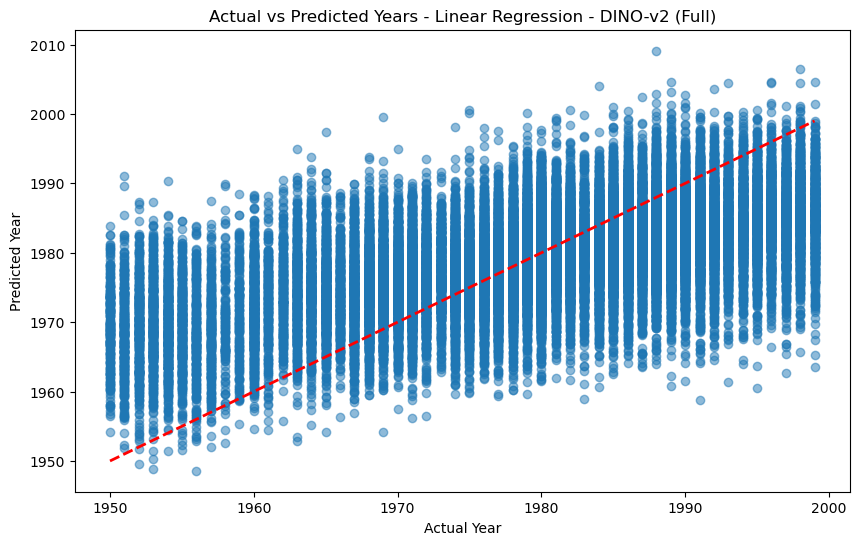

Linear Regression - OpenCLIP (Full):
MAE: 7.48, RMSE: 9.50, R²: 0.38


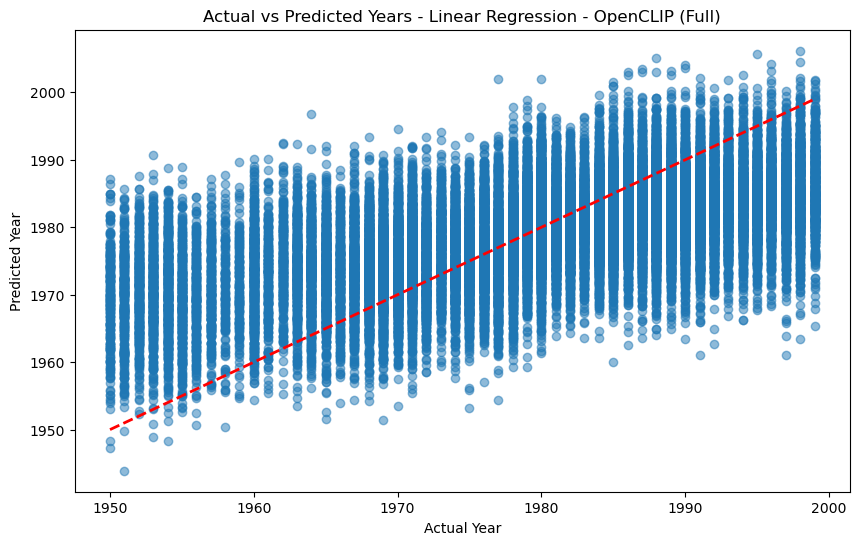

Linear Regression - DINO-v2 (PCA):
MAE: 8.66, RMSE: 10.68, R²: 0.21


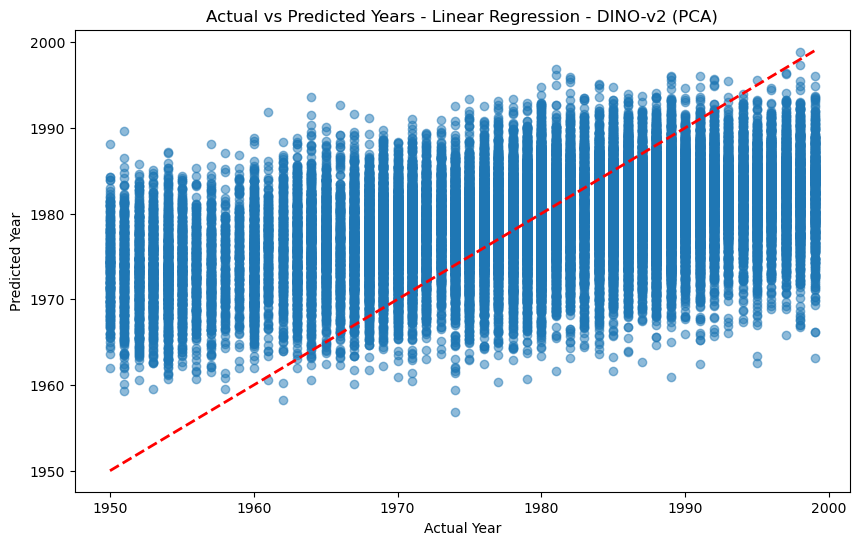

Linear Regression - OpenCLIP (PCA):
MAE: 8.50, RMSE: 10.63, R²: 0.22


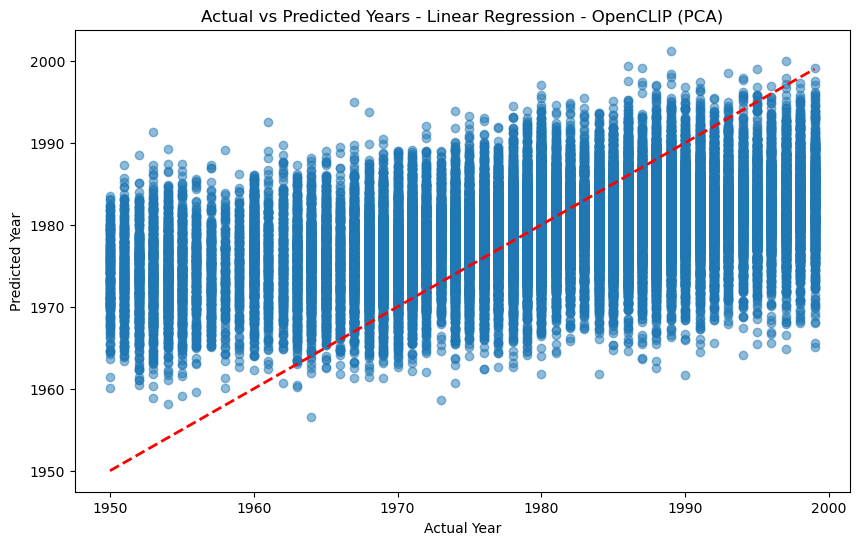

Linear Regression - DINO-v2 (t-SNE):
MAE: 9.79, RMSE: 11.99, R²: 0.01


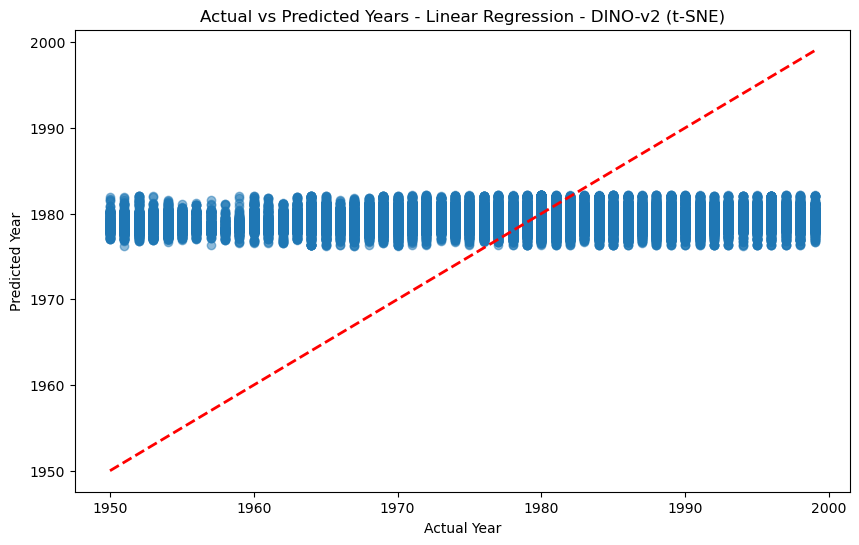

Linear Regression - OpenCLIP (t-SNE):
MAE: 9.81, RMSE: 12.05, R²: 0.00


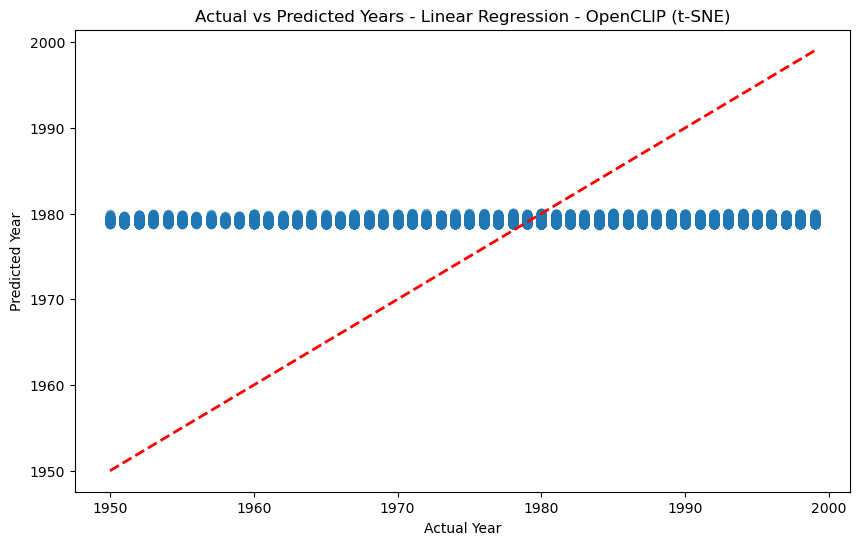

Linear Regression - DINO-v2 (UMAP):
MAE: 9.80, RMSE: 12.00, R²: 0.01


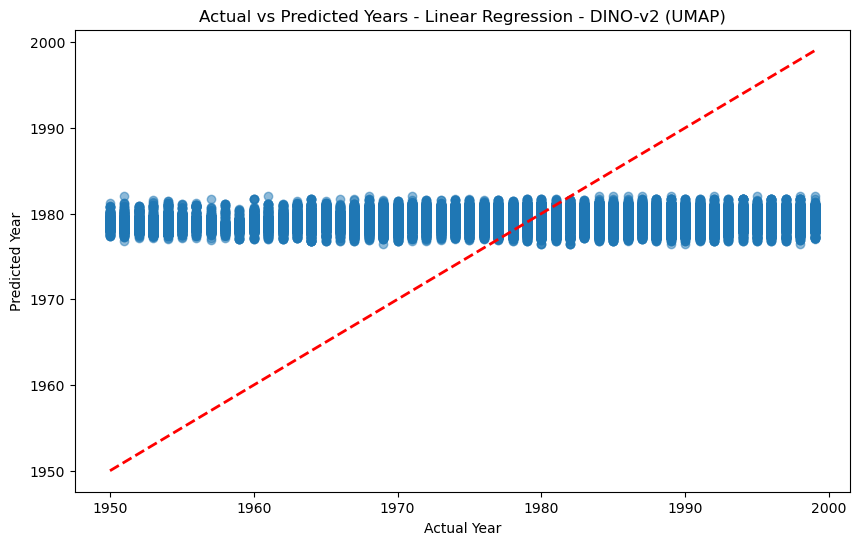

Linear Regression - OpenCLIP (UMAP):
MAE: 9.79, RMSE: 12.01, R²: 0.01


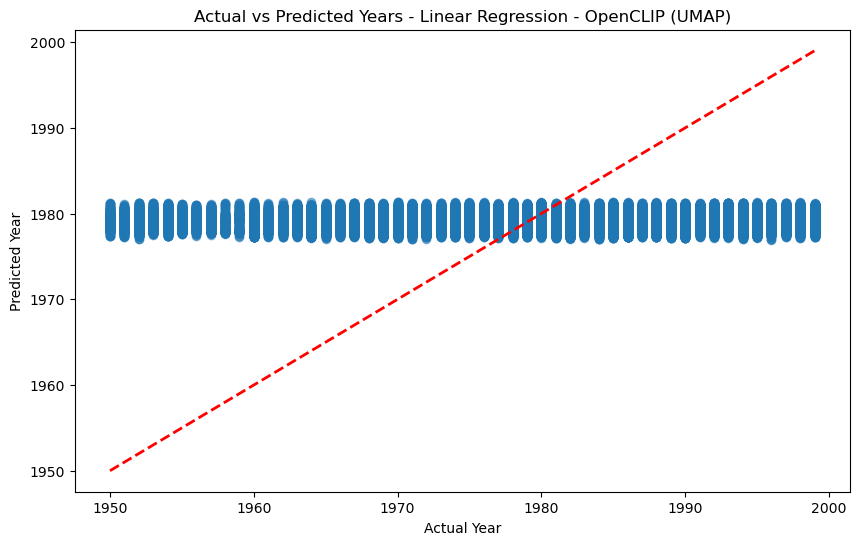

/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.04069e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression - DINO-v2 (Full):
MAE: 7.57, RMSE: 9.52, R²: 0.38


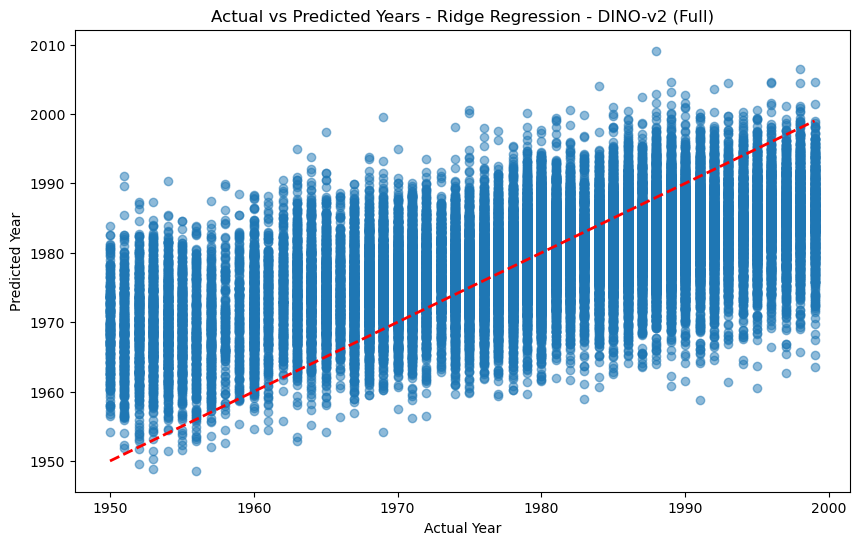

Ridge Regression - OpenCLIP (Full):
MAE: 7.48, RMSE: 9.50, R²: 0.38


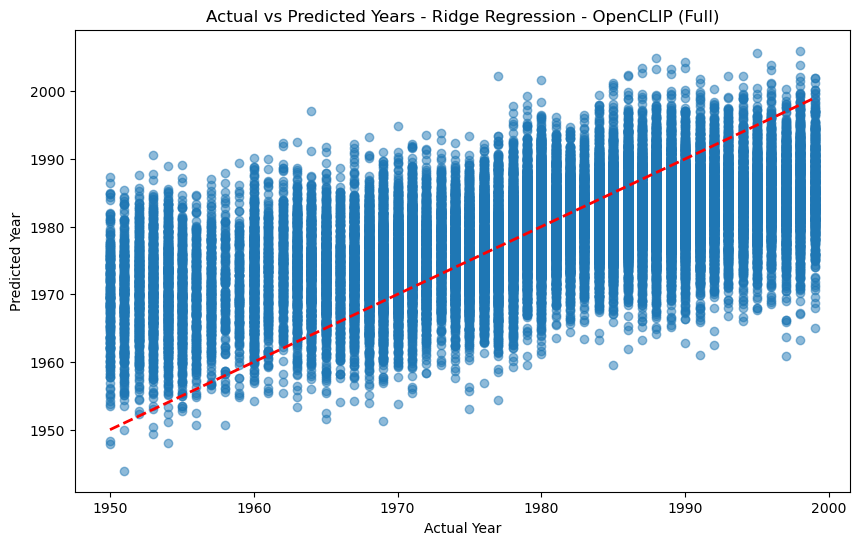

Ridge Regression - DINO-v2 (PCA):
MAE: 8.66, RMSE: 10.68, R²: 0.21


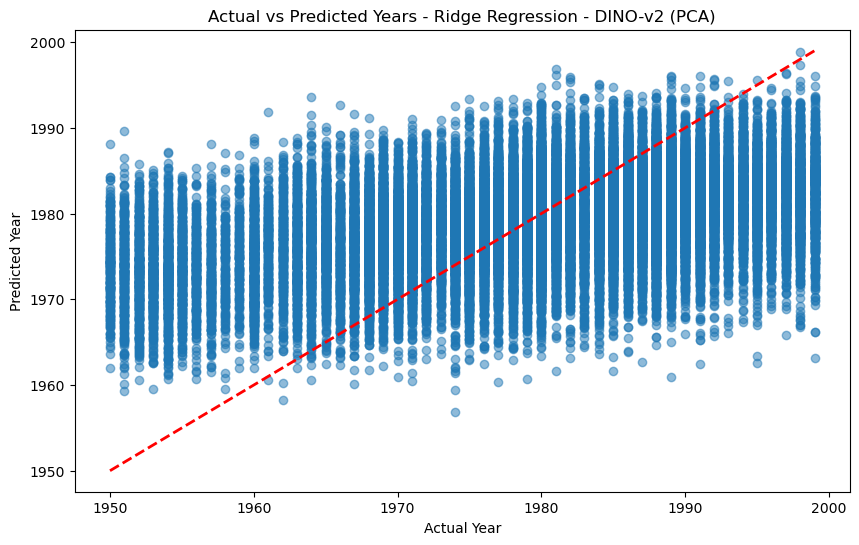

Ridge Regression - OpenCLIP (PCA):
MAE: 8.50, RMSE: 10.63, R²: 0.22


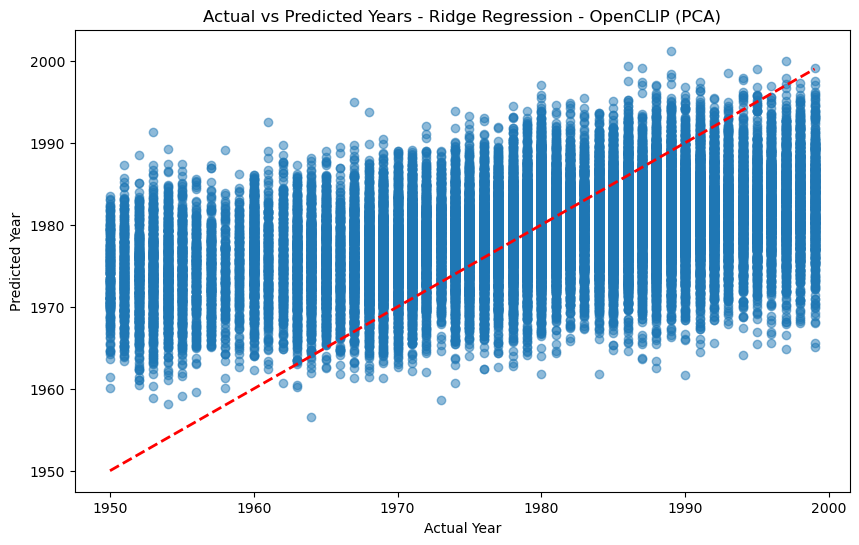

Ridge Regression - DINO-v2 (t-SNE):
MAE: 9.79, RMSE: 11.99, R²: 0.01


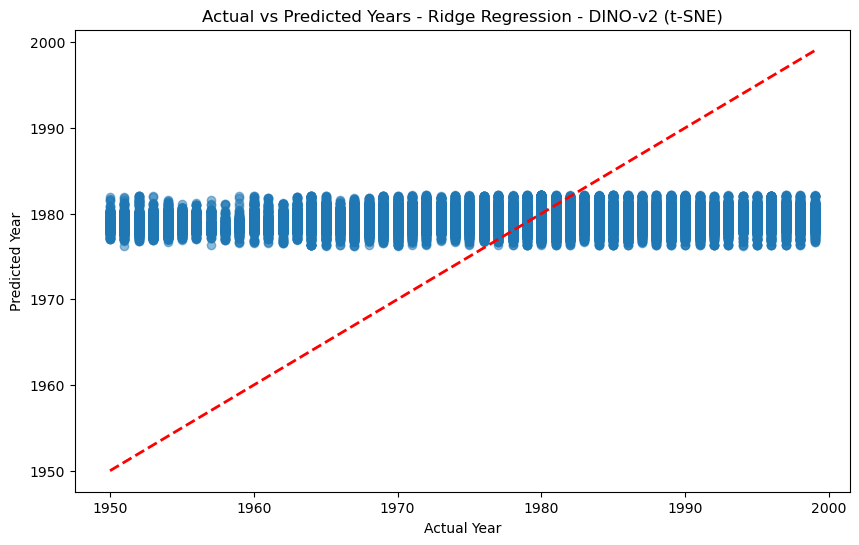

Ridge Regression - OpenCLIP (t-SNE):
MAE: 9.81, RMSE: 12.05, R²: 0.00


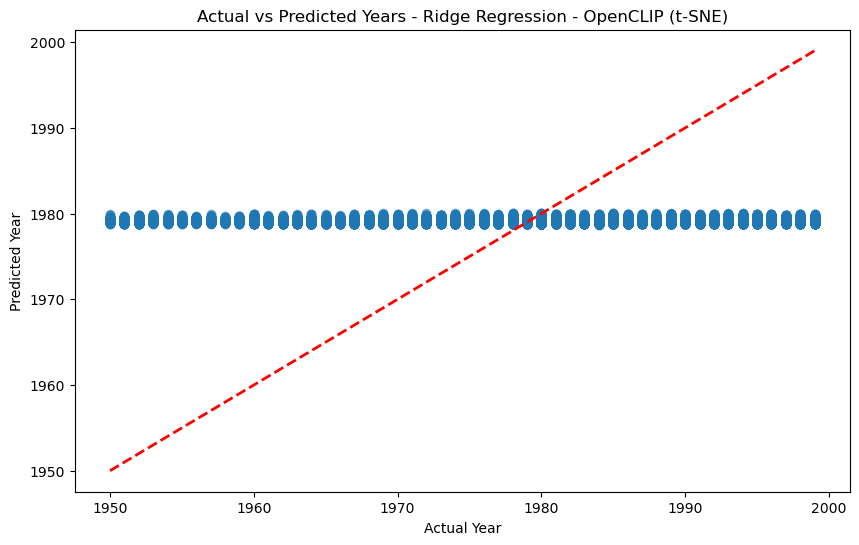

Ridge Regression - DINO-v2 (UMAP):
MAE: 9.80, RMSE: 12.00, R²: 0.01


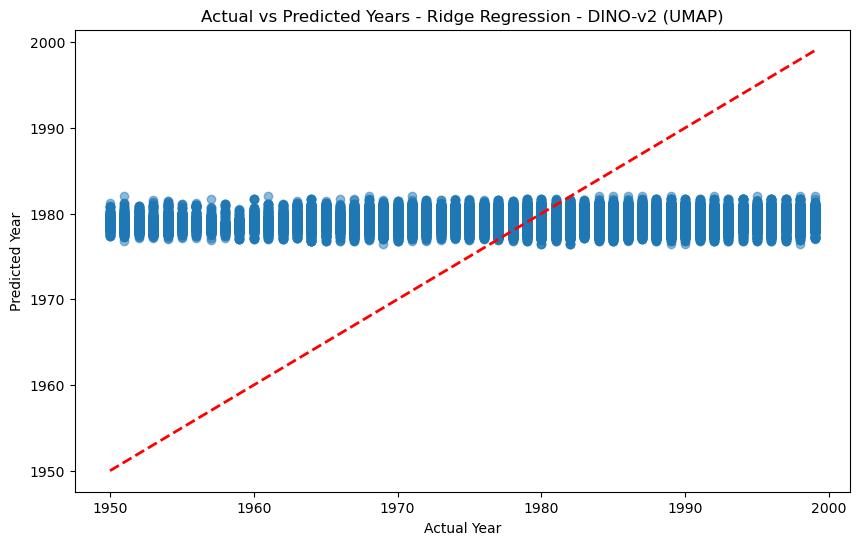

Ridge Regression - OpenCLIP (UMAP):
MAE: 9.79, RMSE: 12.01, R²: 0.01


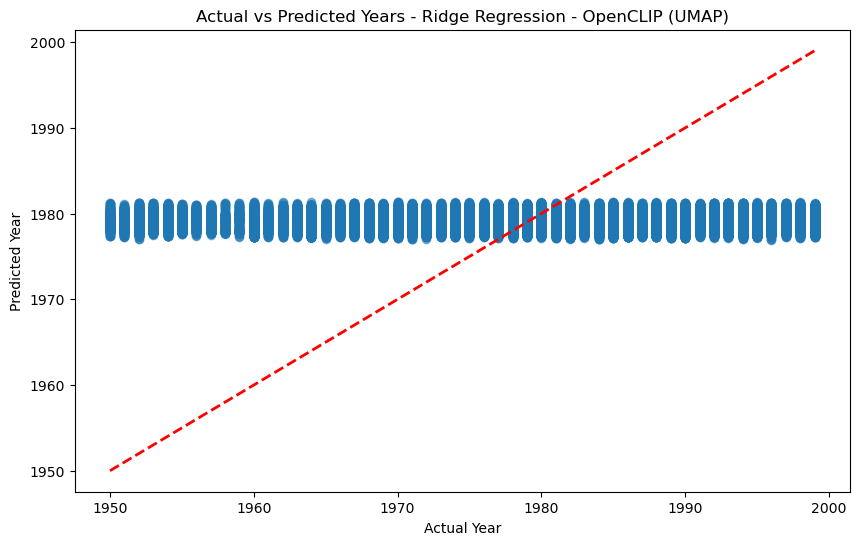

In [29]:

def plot_results(X_test, y_test, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], 'r--', lw=2)
    plt.xlabel('Actual Year')
    plt.ylabel('Predicted Year')
    plt.title(title)
    plt.show()

# Plot results for Linear and Polynomial Regression on full embeddings and PCA-reduced data
for model, model_name in models[:2]:  # Linear and Polynomial
    for X_train, X_test, dataset_name in datasets:  # Full and PCA-reduced
        y_pred = train_and_evaluate(X_train, X_test, y_train, y_test, model, model_name, dataset_name)
        plot_results(X_test, y_test, y_pred, f'Actual vs Predicted Years - {model_name} - {dataset_name}')

# Periodization Analysis

Data types:
X_dino: <class 'numpy.ndarray'>
X_clip: <class 'numpy.ndarray'>
y: <class 'list'>

Shapes/Lengths:
X_dino: (138325, 768)
X_clip: (138325, 512)
y: 138325

Original data size: 138325
Sampled data size: 10000
Converting years to 1-year periods...


100%|██████████| 10000/10000 [00:00<00:00, 1325800.99it/s]

Splitting the data...

Training and evaluating DINO-v2...
Training data shape: (7000, 768)


DINO-v2 - Classification Report:
              precision    recall  f1-score   support

   1950-1950       0.00      0.00      0.00        20
   1951-1951       0.00      0.00      0.00        25
   1952-1952       0.00      0.00      0.00        28
   1953-1953       0.14      0.09      0.11        44
   1954-1954       0.00      0.00      0.00        40
   1955-1955       0.00      0.00      0.00        30
   1956-1956       0.50      0.06      0.10        18
   1957-1957       0.25      0.05      0.08        22
   1958-1958       0.00      0.00      0.00        10
   1959-1959       0.00      0.00      0.00         9
   1960-1960       0.39      0.43      0.41        47
   1961-1961       0.00      0.00      0.00        20
   1962-1962       0.00      0.00      0.00        19
   1963-1963       0.00      0.00      0.00        33
   1964-1964       0.06      0.02      0.03        46
   1965-1965       0.07      0.02      0.03        50
   1966-1966       0.00      0.00      0.00     

/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

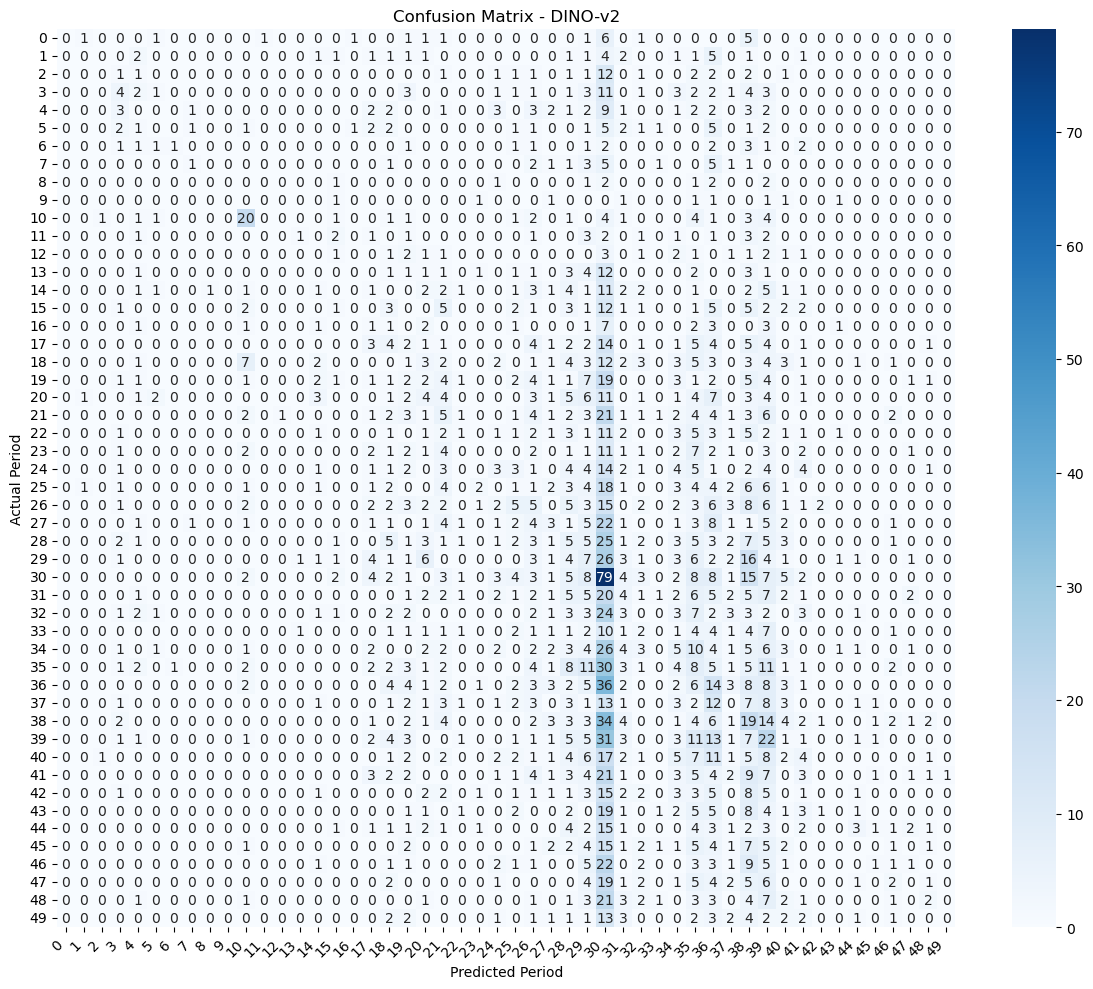


Training and evaluating OpenCLIP...
Training data shape: (7000, 512)
OpenCLIP - Classification Report:
              precision    recall  f1-score   support

   1950-1950       0.00      0.00      0.00        20
   1951-1951       0.00      0.00      0.00        25
   1952-1952       0.25      0.07      0.11        28
   1953-1953       0.06      0.05      0.05        44
   1954-1954       0.06      0.03      0.04        40
   1955-1955       0.00      0.00      0.00        30
   1956-1956       0.00      0.00      0.00        18
   1957-1957       0.00      0.00      0.00        22
   1958-1958       0.00      0.00      0.00        10
   1959-1959       0.00      0.00      0.00         9
   1960-1960       0.25      0.28      0.27        47
   1961-1961       0.00      0.00      0.00        20
   1962-1962       0.00      0.00      0.00        19
   1963-1963       0.00      0.00      0.00        33
   1964-1964       0.06      0.02      0.03        46
   1965-1965       0.05      0.

/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/Caskroom/miniconda/base/envs/dating-images/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

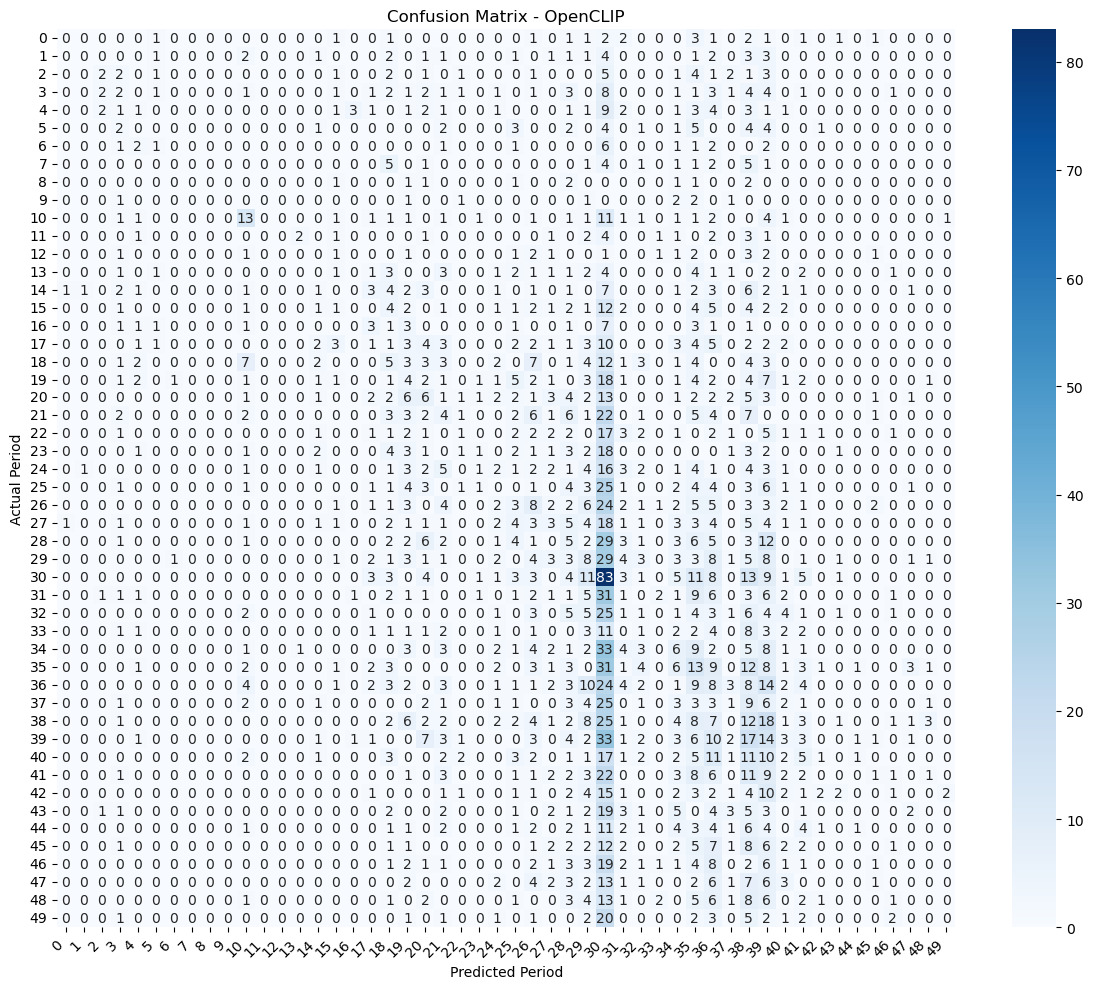


Analyzing misclassifications for DINO-v2...


100%|██████████| 50/50 [00:00<00:00, 423.24it/s]


True 1950-1950 classified as 1951-1951: 1 times
True 1950-1950 classified as 1955-1955: 1 times
True 1950-1950 classified as 1961-1961: 1 times
True 1950-1950 classified as 1966-1966: 1 times
True 1950-1950 classified as 1969-1969: 1 times
True 1950-1950 classified as 1970-1970: 1 times
True 1950-1950 classified as 1971-1971: 1 times
True 1950-1950 classified as 1979-1979: 1 times
True 1950-1950 classified as 1980-1980: 6 times
True 1950-1950 classified as 1982-1982: 1 times
True 1950-1950 classified as 1988-1988: 5 times
True 1951-1951 classified as 1954-1954: 2 times
True 1951-1951 classified as 1964-1964: 1 times
True 1951-1951 classified as 1965-1965: 1 times
True 1951-1951 classified as 1967-1967: 1 times
True 1951-1951 classified as 1968-1968: 1 times
True 1951-1951 classified as 1969-1969: 1 times
True 1951-1951 classified as 1970-1970: 1 times
True 1951-1951 classified as 1978-1978: 1 times
True 1951-1951 classified as 1979-1979: 1 times
True 1951-1951 classified as 1980-1980: 

True 1950-1950 classified as 1955-1955: 1 times
True 1950-1950 classified as 1965-1965: 1 times
True 1950-1950 classified as 1968-1968: 1 times
True 1950-1950 classified as 1976-1976: 1 times
True 1950-1950 classified as 1978-1978: 1 times
True 1950-1950 classified as 1979-1979: 1 times
True 1950-1950 classified as 1980-1980: 2 times
True 1950-1950 classified as 1981-1981: 2 times
True 1950-1950 classified as 1985-1985: 3 times
True 1950-1950 classified as 1986-1986: 1 times
True 1950-1950 classified as 1988-1988: 2 times
True 1950-1950 classified as 1989-1989: 1 times
True 1950-1950 classified as 1991-1991: 1 times
True 1950-1950 classified as 1993-1993: 1 times
True 1950-1950 classified as 1995-1995: 1 times
True 1951-1951 classified as 1955-1955: 1 times
True 1951-1951 classified as 1960-1960: 2 times
True 1951-1951 classified as 1964-1964: 1 times
True 1951-1951 classified as 1968-1968: 2 times
True 1951-1951 classified as 1970-1970: 1 times
True 1951-1951 classified as 1971-1971: 

100%|██████████| 50/50 [00:00<00:00, 445.35it/s]


True 1985-1985 classified as 1990-1990: 1 times
True 1985-1985 classified as 1991-1991: 3 times
True 1985-1985 classified as 1992-1992: 1 times
True 1985-1985 classified as 1994-1994: 1 times
True 1985-1985 classified as 1997-1997: 3 times
True 1985-1985 classified as 1998-1998: 1 times
True 1986-1986 classified as 1960-1960: 4 times
True 1986-1986 classified as 1965-1965: 1 times
True 1986-1986 classified as 1967-1967: 2 times
True 1986-1986 classified as 1968-1968: 3 times
True 1986-1986 classified as 1969-1969: 2 times
True 1986-1986 classified as 1971-1971: 3 times
True 1986-1986 classified as 1974-1974: 1 times
True 1986-1986 classified as 1975-1975: 1 times
True 1986-1986 classified as 1976-1976: 1 times
True 1986-1986 classified as 1977-1977: 2 times
True 1986-1986 classified as 1978-1978: 3 times
True 1986-1986 classified as 1979-1979: 10 times
True 1986-1986 classified as 1980-1980: 24 times
True 1986-1986 classified as 1981-1981: 4 times
True 1986-1986 classified as 1982-1982

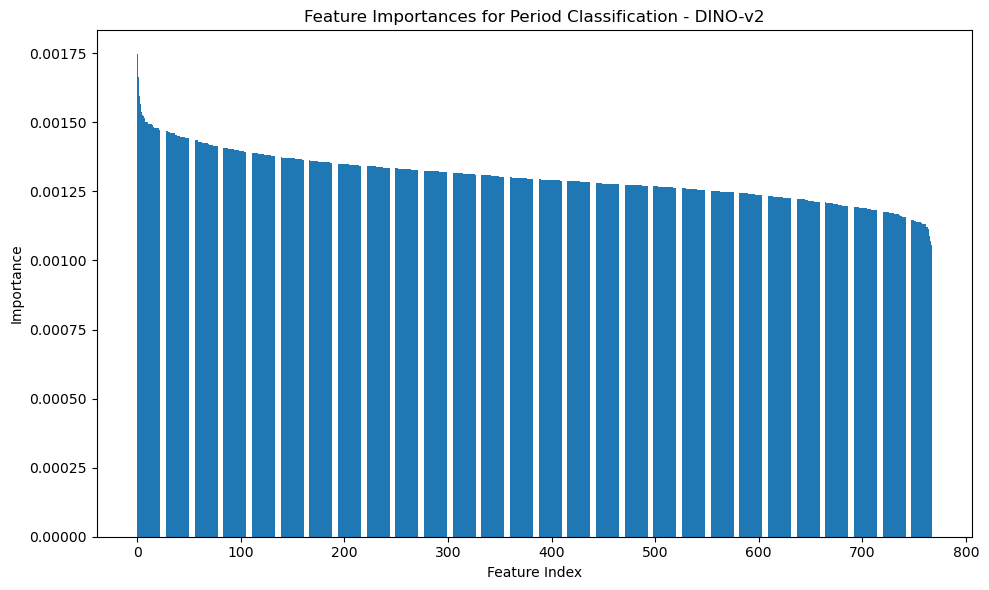

Top 10 most important features for DINO-v2:
Feature 316: 0.0017
Feature 521: 0.0017
Feature 37: 0.0016
Feature 236: 0.0016
Feature 472: 0.0015
Feature 86: 0.0015
Feature 341: 0.0015
Feature 686: 0.0015
Feature 680: 0.0015
Feature 476: 0.0015

Plotting feature importance for OpenCLIP...


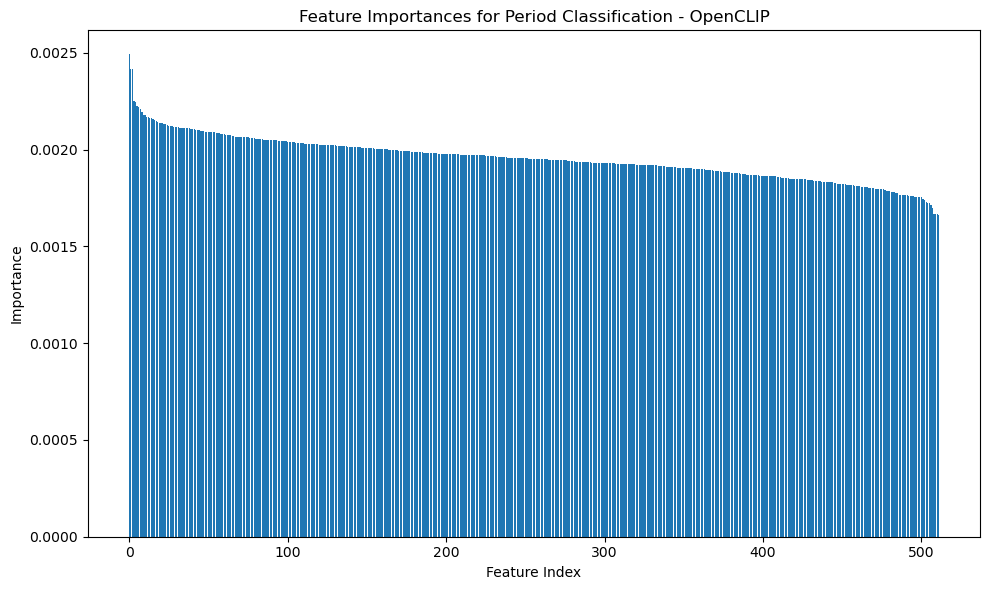

Top 10 most important features for OpenCLIP:
Feature 416: 0.0025
Feature 253: 0.0024
Feature 262: 0.0024
Feature 84: 0.0023
Feature 330: 0.0022
Feature 338: 0.0022
Feature 265: 0.0022
Feature 179: 0.0022
Feature 495: 0.0022
Feature 420: 0.0022

Analyzing temporal distance of misclassifications for DINO-v2...
Average distance of misclassifications: 1.54 periods
Median distance of misclassifications: 1.00 periods
Percentage of early predictions: 48.72%
Percentage of late predictions: 51.28%


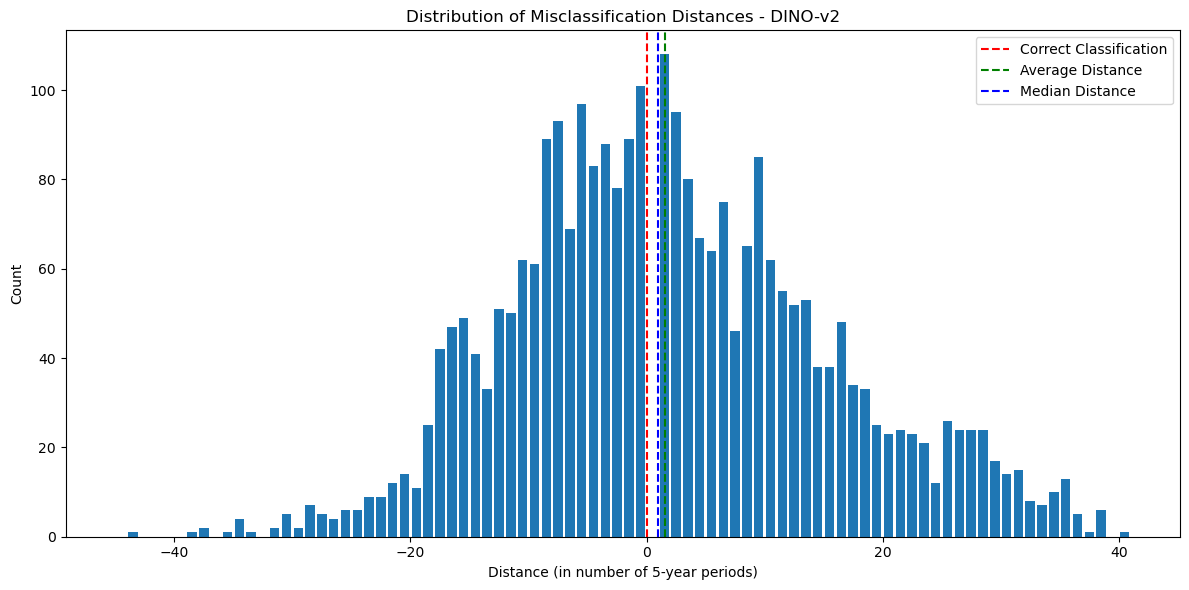

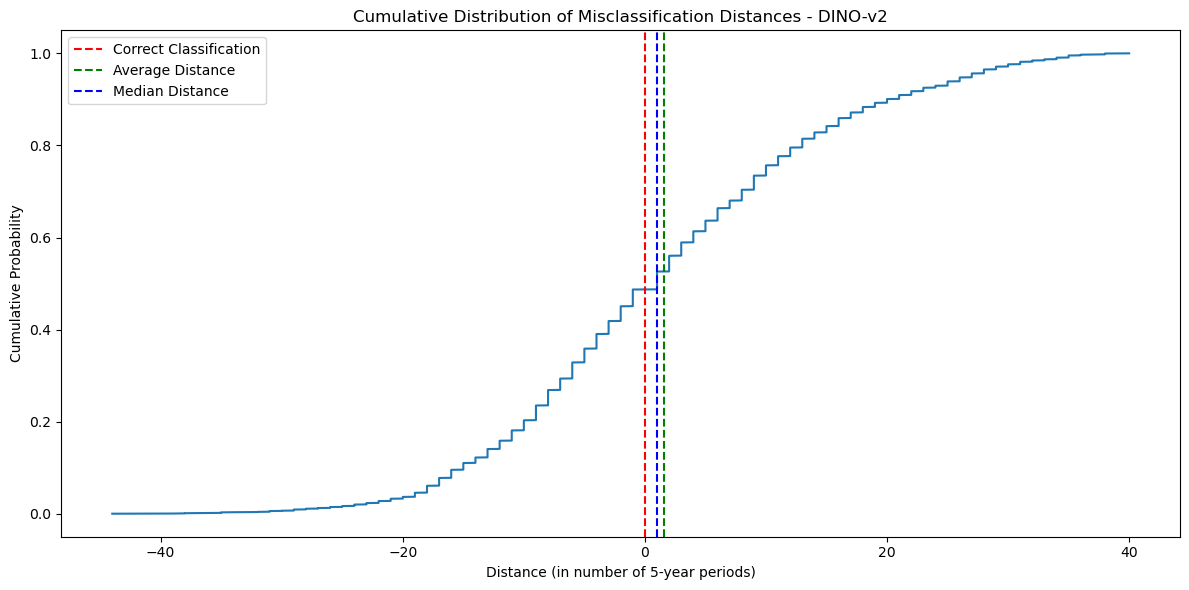


Analyzing temporal distance of misclassifications for OpenCLIP...
Average distance of misclassifications: 1.43 periods
Median distance of misclassifications: 1.00 periods
Percentage of early predictions: 48.99%
Percentage of late predictions: 51.01%


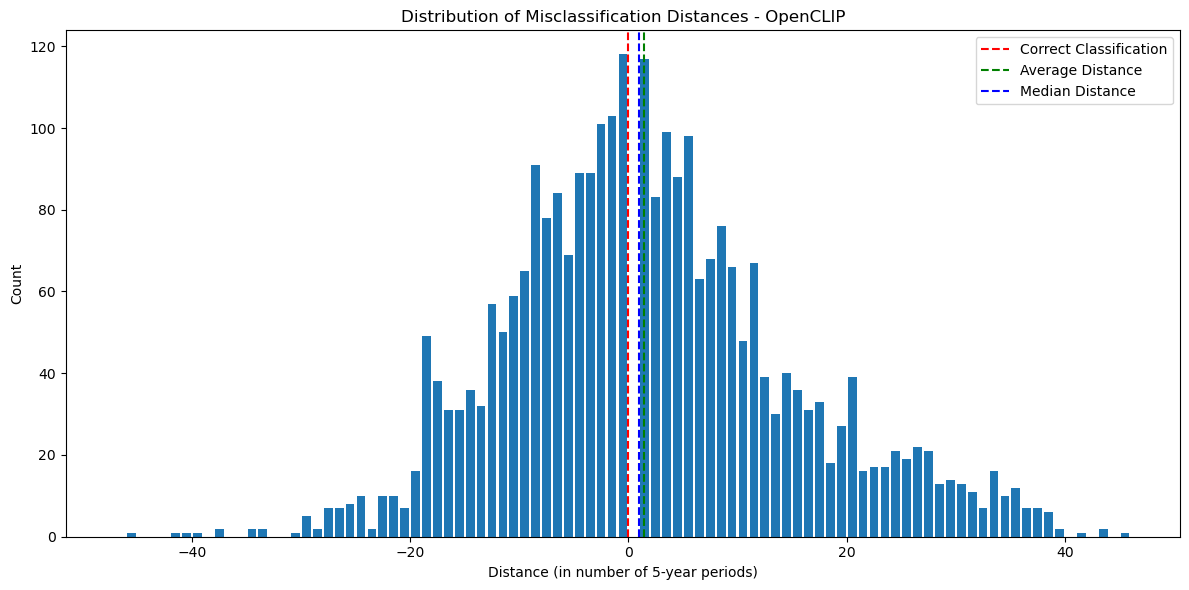

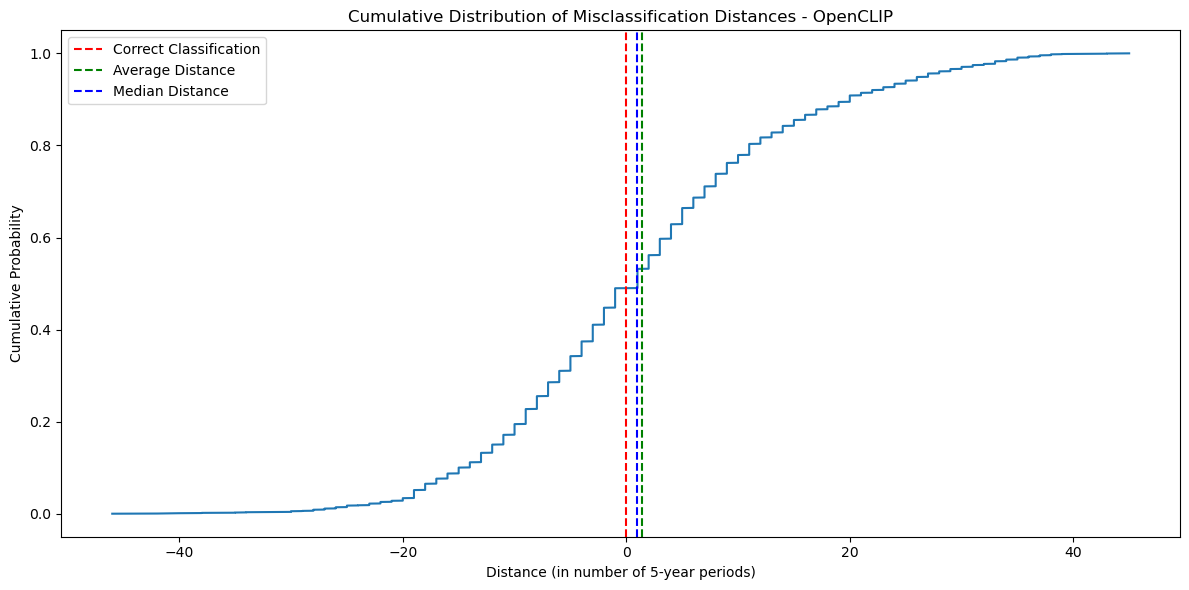


Statistical Comparison of Misclassification Distances
Mann-Whitney U test:
Statistic: 3880901.5, p-value: 0.7266418318912085
There is no statistically significant difference in misclassification distances.

Kolmogorov-Smirnov test:
Statistic: 0.03461746014187036, p-value: 0.0692398489121399
There is no significant difference in the distributions of misclassification distances.

Bootstrap 95% Confidence Interval for difference in mean distances:
(-0.5933, 0.8202)
No significant difference in mean distances

Effect size (Cohen's d): 0.0085
The effect size is small


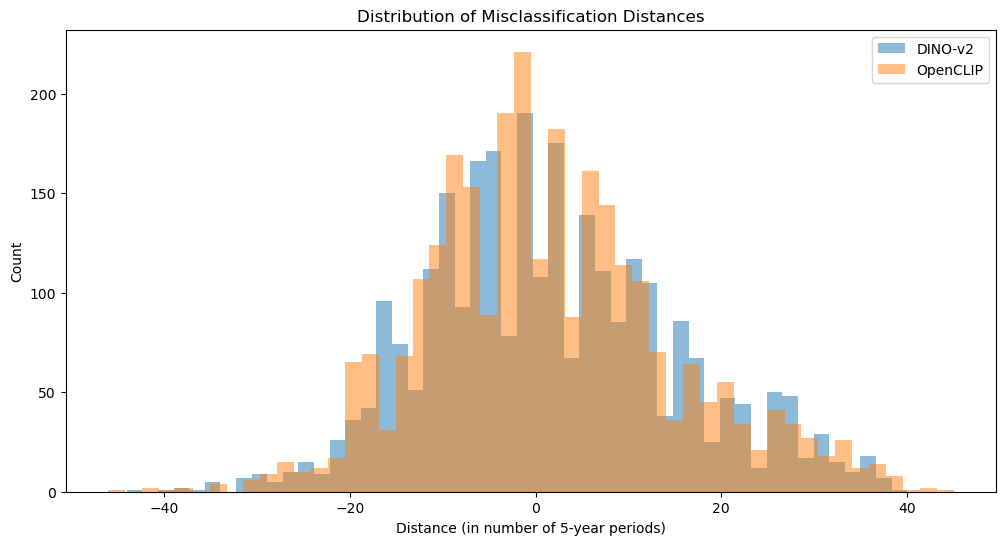

In [40]:
_bin_size = 1
_sample_size = 10000

# Sampling function
def sample_data(X_dino, X_clip, y, sample_size=2500, random_state=42):
    if len(y) > sample_size:
        indices = np.random.RandomState(random_state).choice(len(y), sample_size, replace=False)
        
        # Handle different data types
        if isinstance(X_dino, np.ndarray):
            X_dino_sampled = X_dino[indices]
        elif isinstance(X_dino, list):
            X_dino_sampled = [X_dino[i] for i in indices]
        elif isinstance(X_dino, pd.DataFrame):
            X_dino_sampled = X_dino.iloc[indices]
        else:
            raise TypeError("Unsupported data type for X_dino")
        
        if isinstance(X_clip, np.ndarray):
            X_clip_sampled = X_clip[indices]
        elif isinstance(X_clip, list):
            X_clip_sampled = [X_clip[i] for i in indices]
        elif isinstance(X_clip, pd.DataFrame):
            X_clip_sampled = X_clip.iloc[indices]
        else:
            raise TypeError("Unsupported data type for X_clip")
        
        y_sampled = y[indices] if isinstance(y, np.ndarray) else [y[i] for i in indices]
        
        return X_dino_sampled, X_clip_sampled, y_sampled
    return X_dino, X_clip, y

# Print data types and shapes
print("Data types:")
print(f"X_dino: {type(X_dino)}")
print(f"X_clip: {type(X_clip)}")
print(f"y: {type(y)}")

print("\nShapes/Lengths:")
print(f"X_dino: {np.shape(X_dino) if hasattr(X_dino, 'shape') else len(X_dino)}")
print(f"X_clip: {np.shape(X_clip) if hasattr(X_clip, 'shape') else len(X_clip)}")
print(f"y: {np.shape(y) if hasattr(y, 'shape') else len(y)}")

# Sample the data
print(f"\nOriginal data size: {len(y)}")
X_dino_sampled, X_clip_sampled, y_sampled = sample_data(X_dino, X_clip, y, sample_size=_sample_size)
print(f"Sampled data size: {len(y_sampled)}")

# Function to assign 5-year periods
def assign_period(year, bin_size=_bin_size):
    period_start = (year // bin_size) * bin_size
    return f"{period_start}-{period_start + bin_size - 1}"

# Convert years to 5-year periods
print(f"Converting years to {_bin_size}-year periods...")
periods = np.array([assign_period(year) for year in tqdm(y_sampled)])


# Split the data
print("Splitting the data...")
X_dino_train, X_dino_test, X_clip_train, X_clip_test, periods_train, periods_test = train_test_split(
    X_dino_sampled, X_clip_sampled, periods, test_size=0.3, random_state=42, stratify=periods)

# Function to train and evaluate a classifier
def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, model_name):
    print(f"\nTraining and evaluating {model_name}...")
    print(f"Training data shape: {X_train.shape}")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"{model_name} - Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Period')
    plt.xlabel('Predicted Period')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return clf, y_pred

# Train and evaluate classifiers
dino_clf, dino_pred = train_and_evaluate_classifier(X_dino_train, X_dino_test, periods_train, periods_test, "DINO-v2")
clip_clf, clip_pred = train_and_evaluate_classifier(X_clip_train, X_clip_test, periods_train, periods_test, "OpenCLIP")

# Analyze misclassifications
def analyze_misclassifications(y_true, y_pred, embedding):
    print(f"\nAnalyzing misclassifications for {embedding}...")
    misclassified = y_true != y_pred
    for true_period in tqdm(np.unique(y_true)):
        for pred_period in np.unique(y_pred):
            if true_period != pred_period:
                count = np.sum((y_true == true_period) & (y_pred == pred_period) & misclassified)
                if count > 0:
                    print(f"True {true_period} classified as {pred_period}: {count} times")

analyze_misclassifications(periods_test, dino_pred, "DINO-v2")
analyze_misclassifications(periods_test, clip_pred, "OpenCLIP")

# Feature importance for period classification
def plot_feature_importance(clf, X_train, embedding):
    print(f"\nPlotting feature importance for {embedding}...")
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances for Period Classification - {embedding}")
    plt.bar(range(len(importances)), importances[indices])
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    # Print top 10 most important features
    print(f"Top 10 most important features for {embedding}:")
    for i in range(10):
        print(f"Feature {indices[i]}: {importances[indices[i]]:.4f}")

# After training the classifiers
plot_feature_importance(dino_clf, X_dino_train, "DINO-v2")
plot_feature_importance(clip_clf, X_clip_train, "OpenCLIP")


def create_period_index(periods):
    unique_periods = sorted(list(set(periods)))
    return {period: index for index, period in enumerate(unique_periods)}

def calculate_distances(y_true, y_pred, period_to_index):
    return [period_to_index[pred] - period_to_index[true] for true, pred in zip(y_true, y_pred) if true != pred]

def analyze_temporal_distance(y_true, y_pred, embedding, period_to_index):
    print(f"\nAnalyzing temporal distance of misclassifications for {embedding}...")
    
    distances = calculate_distances(y_true, y_pred, period_to_index)
    distances = np.array(distances)
    
    avg_distance = np.mean(distances)
    median_distance = np.median(distances)
    
    print(f"Average distance of misclassifications: {avg_distance:.2f} periods")
    print(f"Median distance of misclassifications: {median_distance:.2f} periods")
    print(f"Percentage of early predictions: {100 * np.mean(distances < 0):.2f}%")
    print(f"Percentage of late predictions: {100 * np.mean(distances > 0):.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.hist(distances, bins=range(min(distances)-1, max(distances)+2), align='mid', rwidth=0.8)
    plt.title(f"Distribution of Misclassification Distances - {embedding}")
    plt.xlabel("Distance (in number of 5-year periods)")
    plt.ylabel("Count")
    plt.axvline(x=0, color='r', linestyle='--', label='Correct Classification')
    plt.axvline(x=avg_distance, color='g', linestyle='--', label='Average Distance')
    plt.axvline(x=median_distance, color='b', linestyle='--', label='Median Distance')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot cumulative distribution
    plt.figure(figsize=(12, 6))
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
    plt.plot(sorted_distances, cumulative)
    plt.title(f"Cumulative Distribution of Misclassification Distances - {embedding}")
    plt.xlabel("Distance (in number of 5-year periods)")
    plt.ylabel("Cumulative Probability")
    plt.axvline(x=0, color='r', linestyle='--', label='Correct Classification')
    plt.axvline(x=avg_distance, color='g', linestyle='--', label='Average Distance')
    plt.axvline(x=median_distance, color='b', linestyle='--', label='Median Distance')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return distances

def compare_models(dino_distances, clip_distances):
    print("\nStatistical Comparison of Misclassification Distances")
    print("=====================================================")

    # 1. Mann-Whitney U test
    statistic, p_value = stats.mannwhitneyu(dino_distances, clip_distances, alternative='two-sided')
    print(f"Mann-Whitney U test:")
    print(f"Statistic: {statistic}, p-value: {p_value}")
    if p_value < 0.05:
        print("The difference in misclassification distances is statistically significant.")
    else:
        print("There is no statistically significant difference in misclassification distances.")

    # 2. Kolmogorov-Smirnov test
    statistic, p_value = stats.ks_2samp(dino_distances, clip_distances)
    print(f"\nKolmogorov-Smirnov test:")
    print(f"Statistic: {statistic}, p-value: {p_value}")
    if p_value < 0.05:
        print("The distributions of misclassification distances are significantly different.")
    else:
        print("There is no significant difference in the distributions of misclassification distances.")

    # 3. Bootstrap confidence intervals
    def diff_in_means(x, y):
        return np.mean(x) - np.mean(y)

    boot_result = bootstrap((dino_distances, clip_distances), diff_in_means, n_resamples=10000)
    ci = boot_result.confidence_interval
    print(f"\nBootstrap 95% Confidence Interval for difference in mean distances:")
    print(f"({ci.low:.4f}, {ci.high:.4f})")
    if ci.low > 0:
        print("DINO-v2 has significantly larger mean distance")
    elif ci.high < 0:
        print("OpenCLIP has significantly larger mean distance")
    else:
        print("No significant difference in mean distances")

    # 4. Effect size (Cohen's d)
    mean_diff = np.mean(dino_distances) - np.mean(clip_distances)
    pooled_std = np.sqrt((np.std(dino_distances, ddof=1)**2 + np.std(clip_distances, ddof=1)**2) / 2)
    cohens_d = mean_diff / pooled_std
    print(f"\nEffect size (Cohen's d): {cohens_d:.4f}")
    if abs(cohens_d) < 0.2:
        print("The effect size is small")
    elif abs(cohens_d) < 0.5:
        print("The effect size is medium")
    else:
        print("The effect size is large")

    # Visualize the distributions
    plt.figure(figsize=(12, 6))
    plt.hist(dino_distances, bins=50, alpha=0.5, label='DINO-v2')
    plt.hist(clip_distances, bins=50, alpha=0.5, label='OpenCLIP')
    plt.title("Distribution of Misclassification Distances")
    plt.xlabel("Distance (in number of 5-year periods)")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# After training and evaluating the classifiers
period_to_index = create_period_index(periods_test)

dino_distances = analyze_temporal_distance(periods_test, dino_pred, "DINO-v2", period_to_index)
clip_distances = analyze_temporal_distance(periods_test, clip_pred, "OpenCLIP", period_to_index)

compare_models(dino_distances, clip_distances)

## Dimensionality Reduction and Visualization

Performing PCA on DINO-v2 embeddings...


/var/folders/yd/0br8778n16n7wxd8xcr5qftr0000gn/T/ipykernel_41352/873485789.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis')


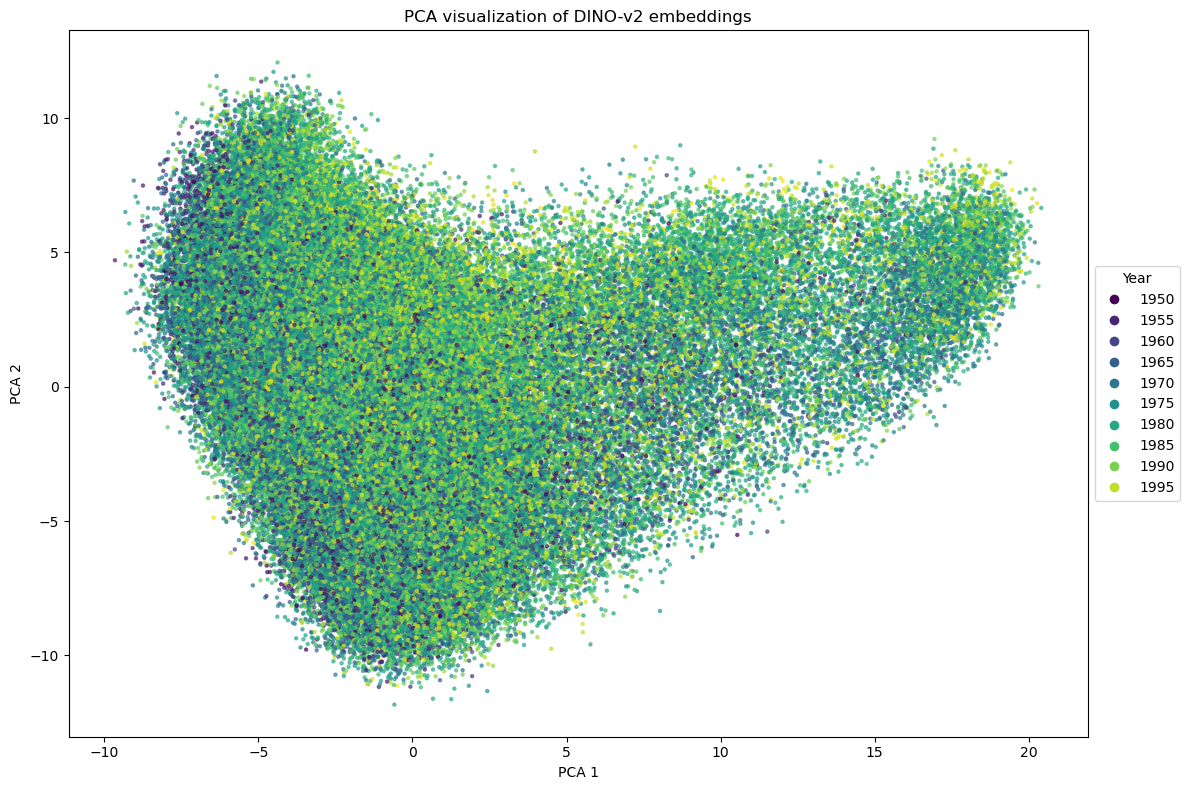

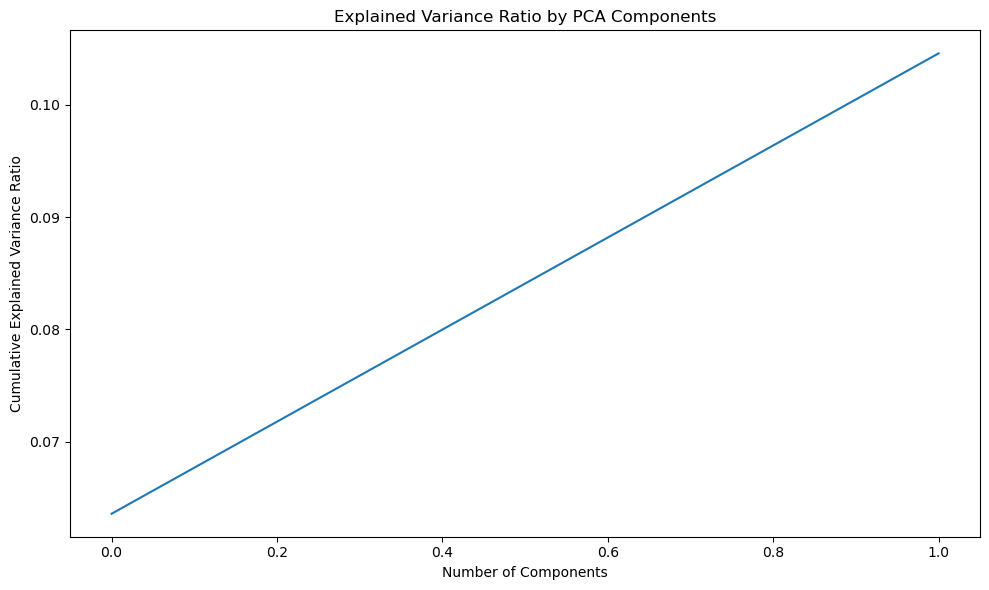

Performing UMAP on DINO-v2 embeddings...


NameError: name 'UMAP' is not defined

In [41]:
def reduce_and_visualize(X, y, method='pca', name='DINO-v2'):
    print(f"Performing {method.upper()} on {name} embeddings...")
    
    # Perform dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'umap':
        reducer = UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca', 'tsne', or 'umap'")
    
    X_reduced = reducer.fit_transform(X)
    
    # Create a color map
    unique_years = sorted(set(y))
    color_map = plt.cm.get_cmap('viridis')
    colors = [color_map(i / len(unique_years)) for i in range(len(unique_years))]
    year_to_color = dict(zip(unique_years, colors))
    
    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], 
                          c=[year_to_color[year] for year in y],
                          alpha=0.6, s=5)
    
    plt.title(f'{method.upper()} visualization of {name} embeddings')
    plt.xlabel(f'{method.upper()} 1')
    plt.ylabel(f'{method.upper()} 2')
    
    # Create a custom legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                  label=str(year), 
                                  markerfacecolor=year_to_color[year], markersize=8)
                       for year in unique_years[::5]]  # Show every 5th year in legend
    plt.legend(handles=legend_elements, title='Year', loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()
    
    if method == 'pca':
        # Plot explained variance ratio
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(reducer.explained_variance_ratio_))
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('Explained Variance Ratio by PCA Components')
        plt.tight_layout()
        plt.show()
    
    return X_reduced, reducer

# Perform PCA, t-SNE and UMAP for both DINO-v2 and OpenCLIP embeddings
X_dino_pca, pca_dino = reduce_and_visualize(X_dino, y, method='pca', name='DINO-v2')
# X_dino_tsne, _ = reduce_and_visualize(X_dino, y, method='tsne', name='DINO-v2')
X_dino_umap, _ = reduce_and_visualize(X_dino, y, method='umap', name='DINO-v2')
X_clip_pca, pca_clip = reduce_and_visualize(X_clip, y, method='pca', name='OpenCLIP')
# X_clip_tsne, _ = reduce_and_visualize(X_clip, y, method='tsne', name='OpenCLIP')
X_clip_umap, _ = reduce_and_visualize(X_clip, y, method='umap', name='OpenCLIP')

# Function to analyze temporal coherence
def analyze_temporal_coherence(X_reduced, y):
    # Calculate pairwise distances
    distances = np.sqrt(((X_reduced[:, None, :] - X_reduced[None, :, :]) ** 2).sum(axis=-1))
    
    # Calculate temporal distances
    temporal_distances = np.abs(y[:, None] - y[None, :])
    
    # Calculate correlation
    correlation = np.corrcoef(distances.flatten(), temporal_distances.flatten())[0, 1]
    
    print(f"Correlation between spatial and temporal distances: {correlation:.4f}")
    
    # Plot relationship
    plt.figure(figsize=(10, 6))
    plt.hexbin(temporal_distances.flatten(), distances.flatten(), gridsize=50, cmap='viridis')
    plt.xlabel('Temporal Distance (years)')
    plt.ylabel('Spatial Distance in Reduced Space')
    plt.title('Relationship between Temporal and Spatial Distances')
    plt.colorbar(label='Count')
    plt.tight_layout()
    plt.show()

# Analyze temporal coherence for each reduction
print("Analyzing temporal coherence for DINO-v2 PCA")
analyze_temporal_coherence(X_dino_pca, y)
# print("\nAnalyzing temporal coherence for DINO-v2 t-SNE")
# analyze_temporal_coherence(X_dino_tsne, y)
print("\nAnalyzing temporal coherence for DINO-v2 UMAP")
analyze_temporal_coherence(X_dino_umap, y)
print("\nAnalyzing temporal coherence for OpenCLIP PCA")
analyze_temporal_coherence(X_clip_pca, y)
# print("\nAnalyzing temporal coherence for OpenCLIP t-SNE")
# analyze_temporal_coherence(X_clip_tsne, y)
print("\nAnalyzing temporal coherence for OpenCLIP UMAP")
analyze_temporal_coherence(X_clip_umap, y)

# Analyze PCA components
def analyze_pca_components(pca, name):
    print(f"\nAnalyzing PCA components for {name}")
    
    # Get the top 10 features for the first two components
    for i in range(2):
        component = pca.components_[i]
        top_features = np.argsort(np.abs(component))[-10:][::-1]
        print(f"\nTop 10 features for component {i+1}:")
        for j, feature in enumerate(top_features, 1):
            print(f"{j}. Feature {feature}: {component[feature]:.4f}")

analyze_pca_components(pca_dino, "DINO-v2")
analyze_pca_components(pca_clip, "OpenCLIP")

# Temporal Bias Analysis

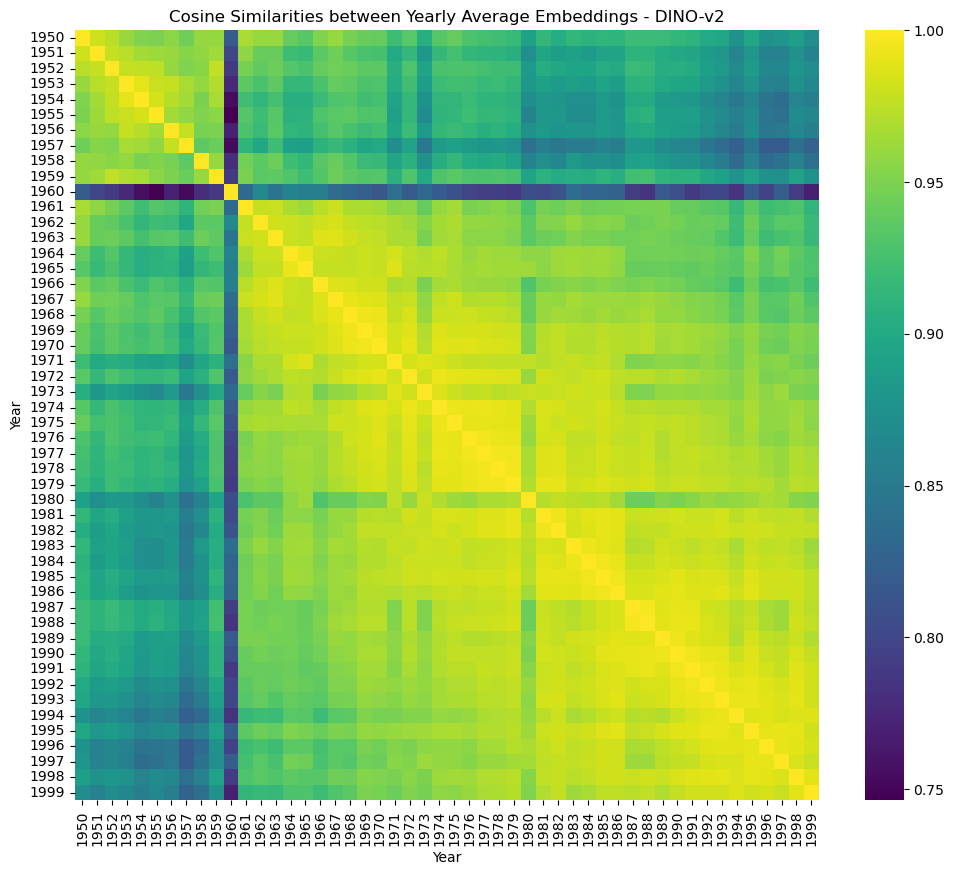

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

def temporal_bias_analysis(X, y, embedding_name):
    # Step 1: Calculate average embeddings for each year
    unique_years = np.unique(y)
    avg_embeddings = np.array([X[y == year].mean(axis=0) for year in unique_years])

    # Step 2: Compute cosine similarities
    similarities = cosine_similarity(avg_embeddings)

    # Step 3: Visualize similarities
    plt.figure(figsize=(12, 10))
    sns.heatmap(similarities, xticklabels=unique_years, yticklabels=unique_years, cmap='viridis')
    plt.title(f'Cosine Similarities between Yearly Average Embeddings - {embedding_name}')
    plt.xlabel('Year')
    plt.ylabel('Year')
    plt.show()

    # Step 4: Analyze prediction errors over time
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    errors = y_test - y_pred

    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, errors, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Prediction Errors Over Time - {embedding_name}')
    plt.xlabel('Actual Year')
    plt.ylabel('Prediction Error (Actual - Predicted)')
    plt.show()

    # Calculate and plot average error by year
    error_by_year = pd.DataFrame({'year': y_test, 'error': errors})
    avg_error_by_year = error_by_year.groupby('year').mean().reset_index()

    plt.figure(figsize=(12, 6))
    plt.bar(avg_error_by_year['year'], avg_error_by_year['error'])
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Average Prediction Error by Year - {embedding_name}')
    plt.xlabel('Year')
    plt.ylabel('Average Prediction Error')
    plt.show()

# Assuming X_dino, X_clip, and y are your embeddings and years
temporal_bias_analysis(X_dino, y, 'DINO-v2')
temporal_bias_analysis(X_clip, y, 'OpenCLIP')

# Temporal Vector Analysis

Analyzing Temporal Concept Vectors for DINO-v2
Spearman correlation between projections and years: 0.5974


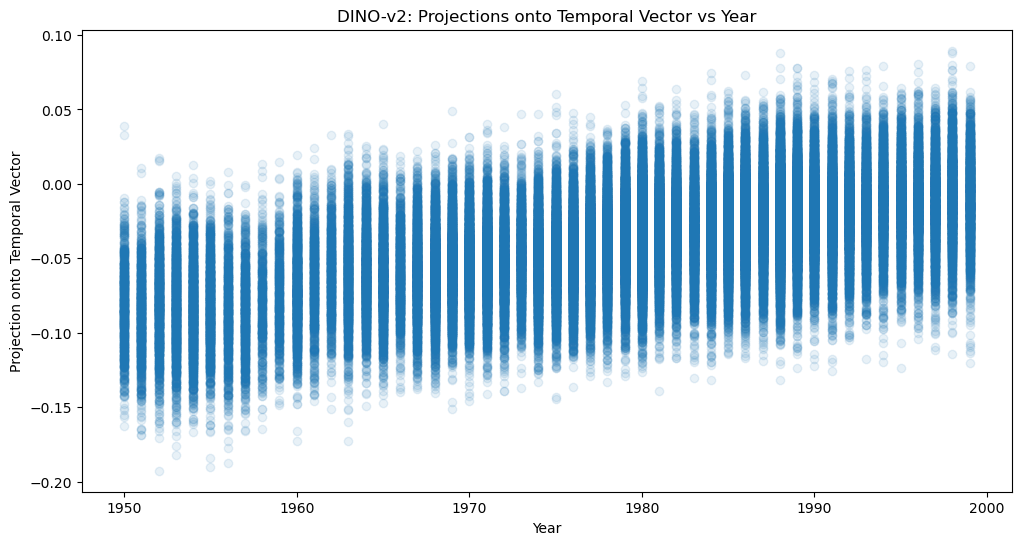

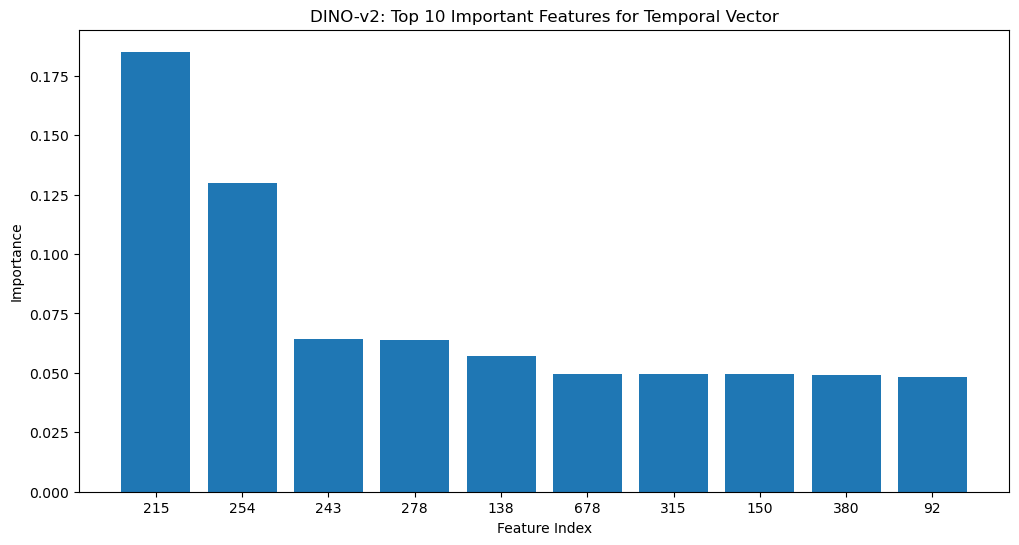

Embedding space traversal along temporal vector:
Step 1 (-3.00 std): [0.36015695 0.14553962 0.57319259 0.52857698 0.20208468]...
Step 2 (-2.00 std): [0.3311651  0.12690077 0.5472569  0.48782313 0.17494424]...
Step 3 (-1.00 std): [0.30217326 0.10826192 0.52132121 0.44706929 0.14780379]...
Step 4 (0.00 std): [0.27318141 0.08962307 0.49538553 0.40631545 0.12066335]...
Step 5 (1.00 std): [0.24418956 0.07098422 0.46944984 0.3655616  0.09352291]...
Step 6 (2.00 std): [0.21519771 0.05234537 0.44351415 0.32480776 0.06638247]...
Step 7 (3.00 std): [0.18620587 0.03370653 0.41757847 0.28405391 0.03924203]...

Analyzing nearest neighbors along the traversal:
indices: [ 69661 102911  89431  22433 109972], type: int64


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
from tqdm import tqdm

def temporal_concept_vectors(X, y, embedding_name, num_samples=1000):
    print(f"Analyzing Temporal Concept Vectors for {embedding_name}")
    
    # 1. Compute the temporal direction vector
    lr = LinearRegression()
    lr.fit(X, y)
    temporal_vector = lr.coef_

    # 2. Normalize the temporal vector
    temporal_vector /= np.linalg.norm(temporal_vector)

    # 3. Project embeddings onto the temporal vector
    projections = X @ temporal_vector

    # 4. Analyze correlation between projections and years
    correlation, _ = spearmanr(projections, y)
    print(f"Spearman correlation between projections and years: {correlation:.4f}")

    # 5. Visualize projections vs years
    plt.figure(figsize=(12, 6))
    plt.scatter(y, projections, alpha=0.1)
    plt.xlabel("Year")
    plt.ylabel("Projection onto Temporal Vector")
    plt.title(f"{embedding_name}: Projections onto Temporal Vector vs Year")
    plt.show()

    # 6. Analyze feature importance
    feature_importance = np.abs(temporal_vector)
    top_features = np.argsort(feature_importance)[-10:][::-1]
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(10), feature_importance[top_features])
    plt.xlabel("Feature Index")
    plt.ylabel("Importance")
    plt.title(f"{embedding_name}: Top 10 Important Features for Temporal Vector")
    plt.xticks(range(10), top_features)
    plt.show()

    # 7. Traverse the embedding space along the temporal vector
    mean_embedding = np.mean(X, axis=0)
    std_embedding = np.std(X, axis=0)
    
    steps = np.linspace(-3, 3, 7)  # From -3 to +3 standard deviations
    traversal = mean_embedding + steps[:, np.newaxis] * std_embedding * temporal_vector

    print("Embedding space traversal along temporal vector:")
    for i, step in enumerate(steps):
        print(f"Step {i+1} ({step:.2f} std): {traversal[i][:5]}...")  # Print first 5 values

    # 8. Analyze nearest neighbors along the traversal
    def find_nearest_neighbors(query, database, k=5):
        distances = np.linalg.norm(database - query, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        return nearest_indices, distances[nearest_indices]

    print("\nAnalyzing nearest neighbors along the traversal:")
    for i, embedding in enumerate(traversal):
        indices, distances = find_nearest_neighbors(embedding, X)
        nearest_years = y[indices]
        print(f"Step {i+1}: Nearest years - {nearest_years}, Avg year: {np.mean(nearest_years):.2f}")

    # 9. Analyze changes in specific features along the temporal vector
    feature_changes = temporal_vector * std_embedding
    top_increasing = np.argsort(feature_changes)[-5:][::-1]
    top_decreasing = np.argsort(feature_changes)[:5]

    print("\nTop 5 increasing features along temporal vector:")
    for idx in top_increasing:
        print(f"Feature {idx}: {feature_changes[idx]:.4f}")

    print("\nTop 5 decreasing features along temporal vector:")
    for idx in top_decreasing:
        print(f"Feature {idx}: {feature_changes[idx]:.4f}")

# Run the analysis for both embedding types
indices = temporal_concept_vectors(X_dino, y, "DINO-v2")
#temporal_concept_vectors(X_clip, y, "OpenCLIP")

In [34]:
y[indices]

TypeError: only integer scalar arrays can be converted to a scalar index

In [1]:
combined = list(zip(year_list, clip_embeddings['X']))

NameError: name 'year_list' is not defined

In [24]:
for i, embedding in enumerate(traversal):
        indices, distances = find_nearest_neighbors(embedding, X)
        print(f"indices: {indices}, type: {indices.dtype}")
        nearest_years = y[indices]
        print(f"Step {i+1}: Nearest years - {nearest_years}, Avg year: {np.mean(nearest_years):.2f}")

NameError: name 'traversal' is not defined

In [26]:
len(y)

138325

In [8]:
# Sort the combined list by the date component
combined_sorted = sorted(combined, key=lambda x: x[0])
dates_sorted, embeddings_sorted = zip(*combined_sorted)

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

normalized_embeddings = embeddings_sorted / np.linalg.norm(embeddings_sorted, axis=1, keepdims=True)

similarities = cosine_similarity(normalized_embeddings)
consecutive_similarities = similarities[np.arange(len(similarities)-1), np.arange(1, len(similarities))]

# Convert similarities to distances
consecutive_distances = 1 - consecutive_similarities

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(consecutive_distances, marker='o', linestyle='-')
plt.xlabel('Time (index of images)')
plt.ylabel('Pairwise Distance Between Consecutive Embeddings')
plt.title('Temporal Changes in Embeddings')
plt.grid(True)
plt.show()


In [31]:
dino_yearly = np.array([np.mean(embeddings_by_year[year]['dino'], axis=0) for year in sorted(embeddings_by_year)])
clip_yearly = np.array([np.mean(embeddings_by_year[year]['clip'], axis=0) for year in sorted(embeddings_by_year)])

years = np.array(sorted(embeddings_by_year))

pca_dino = PCA(n_components=2)  
reduced_dino_yearly = pca_dino.fit_transform(dino_yearly)

pca_clip = PCA(n_components=2) 
reduced_clip_yearly = pca_clip.fit_transform(clip_yearly)


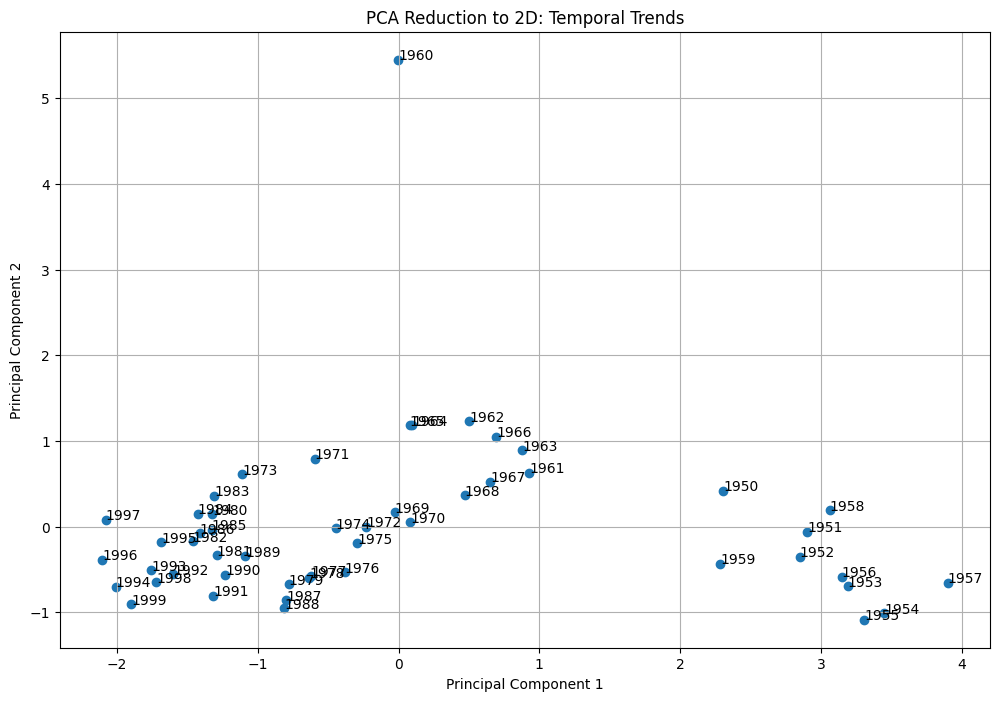

In [39]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Scatter plot of the two principal components
plt.scatter(reduced_dino_yearly[:, 0], reduced_dino_yearly[:, 1])

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(year, (reduced_dino_yearly[i, 0], reduced_dino_yearly[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduction to 2D: Temporal Trends')
plt.grid(True)
plt.show()

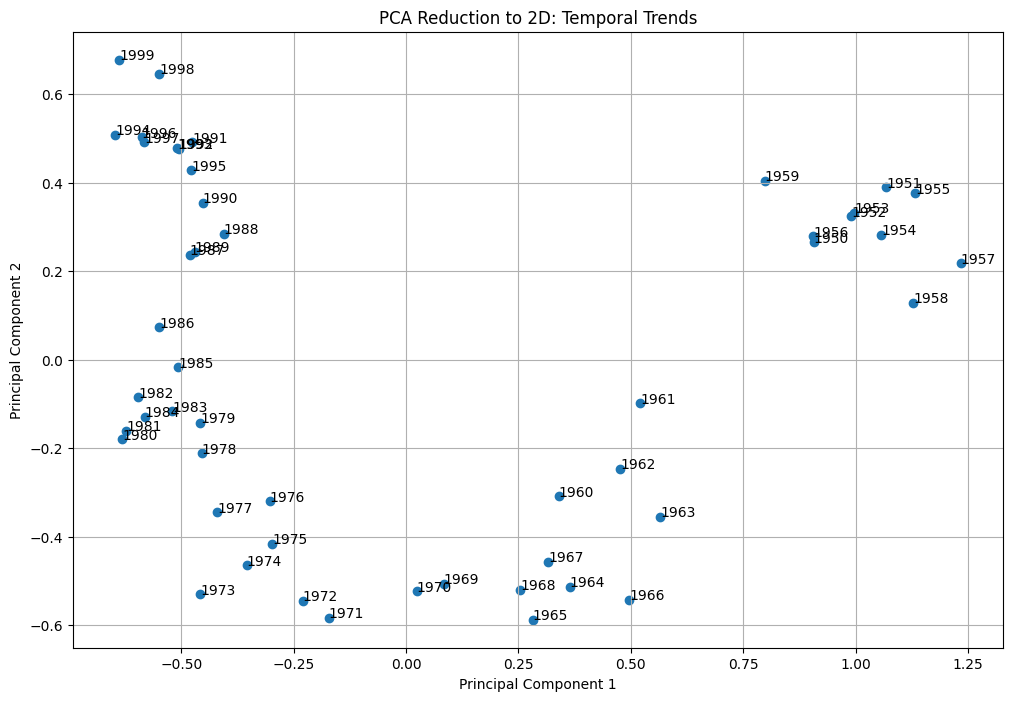

In [33]:
plt.figure(figsize=(12, 8))  # Adjust figure size as needed

# Scatter plot of the two principal components
plt.scatter(reduced_clip_yearly[:, 0], reduced_clip_yearly[:, 1])

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(year, (reduced_clip_yearly[i, 0], reduced_clip_yearly[i, 1]))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Reduction to 2D: Temporal Trends')
plt.grid(True)
plt.show()

In [43]:
pca = PCA(n_components=50)  # Reduce to an intermediate dimension, e.g., 50
pca_result = pca.fit_transform(clip_yearly)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)  # Adjust parameters as needed
tsne_result = tsne.fit_transform(pca_result)

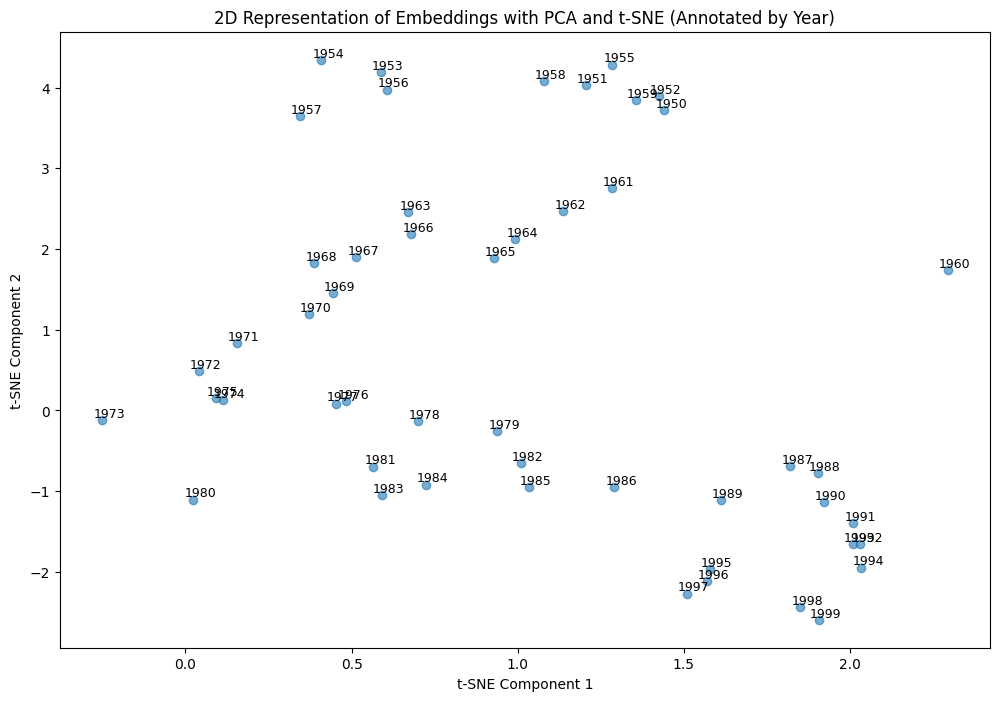

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

# Create a scatter plot of the t-SNE results
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.6)  # Alpha for better visibility

# Annotate each point with its corresponding year
for i, year in enumerate(years):
    plt.annotate(str(year), (tsne_result[i, 0], tsne_result[i, 1]),
                 textcoords="offset points",  # Position text slightly offset from the point
                 xytext=(5,2),  # Distance from the text to the points (x,y)
                 ha='center',  # Horizontal alignment
                 fontsize=9)  # Font size

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('2D Representation of Embeddings with PCA and t-SNE (Annotated by Year)')
plt.show()


In [34]:
X = years.reshape(-1, 1)
y = reduced_clip_yearly


from sklearn.linear_model import LinearRegression

# Initialize a list to store models for each dimension
models = []

# Fit a linear regression model for each dimension of the embeddings
for i in range(y.shape[1]):  # Iterate over each dimension
    model = LinearRegression()
    model.fit(X, y[:, i])
    models.append(model)

In [35]:
for i, model in enumerate(models):
    print(f"Dimension {i+1}:")
    print(f"Coefficients: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"R^2 Score: {model.score(X, y[:, i])}\n")

Dimension 1:
Coefficients: [-0.03925559]
Intercept: 77.51015917568897
R^2 Score: 0.8334700444825347

Dimension 2:
Coefficients: [0.00870088]
Intercept: -17.179880619777137
R^2 Score: 0.10254735743770726



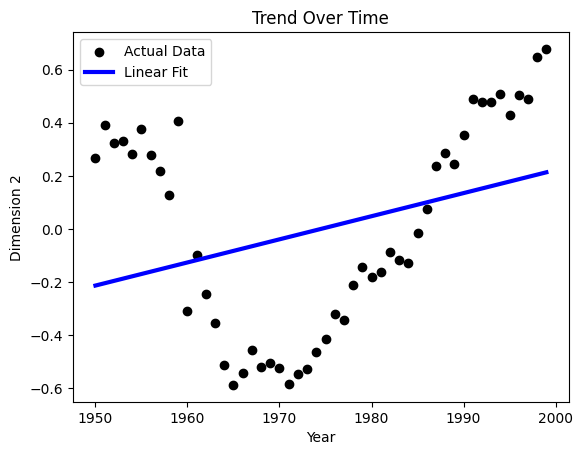

In [38]:
import matplotlib.pyplot as plt

# Choose a dimension to visualize
dimension_idx = 1  # For example, the first dimension

# Scatter plot of the actual data
plt.scatter(X, y[:, dimension_idx], color='black', label='Actual Data')

# Plotting the regression line for the chosen dimension
predicted = models[dimension_idx].predict(X)
plt.plot(X, predicted, color='blue', linewidth=3, label='Linear Fit')

# Optionally, add polynomial fit if you've done polynomial regression
# predicted_poly = poly_models[dimension_idx].predict(X_poly)
# plt.plot(X, predicted_poly, color='red', linewidth=3, label='Polynomial Fit')

plt.xlabel('Year')
plt.ylabel(f'Dimension {dimension_idx + 1}')
plt.title('Trend Over Time')
plt.legend()
plt.show()

In [46]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

# Initialize a list to store polynomial models for each dimension
poly_models = []

# Fit a polynomial regression model for each dimension of the embeddings
for i in range(y.shape[1]):
    model = LinearRegression()
    model.fit(X_poly, y[:, i])
    poly_models.append(model)

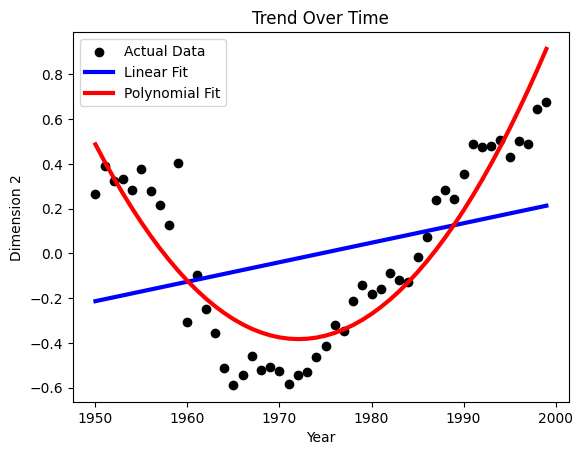

In [50]:
import matplotlib.pyplot as plt

# Choose a dimension to visualize
dimension_idx = 1  # For example, the first dimension

# Scatter plot of the actual data
plt.scatter(X, y[:, dimension_idx], color='black', label='Actual Data')

# Plotting the regression line for the chosen dimension
predicted = models[dimension_idx].predict(X)
plt.plot(X, predicted, color='blue', linewidth=3, label='Linear Fit')

# Optionally, add polynomial fit if you've done polynomial regression
predicted_poly = poly_models[dimension_idx].predict(X_poly)
plt.plot(X, predicted_poly, color='red', linewidth=3, label='Polynomial Fit')

plt.xlabel('Year')
plt.ylabel(f'Dimension {dimension_idx + 1}')
plt.title('Trend Over Time')
plt.legend()
plt.show()


In [ ]:
for i in range(n_components):
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    plt.plot(years_sorted, reduced_data[:, i], marker='o', linestyle='-', label=f'PC{i+1}')
    plt.xlabel('Year')
    plt.ylabel(f'Score of Principal Component {i+1}')
    plt.title(f'Temporal Trend of Principal Component {i+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming 'embeddings' is a list or array of your embeddings, ordered by time
# Convert embeddings to a normalized form if they are not already normalized
# Normalize embeddings to ensure cosine similarity works correctly
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Compute cosine similarities between consecutive embeddings
# Note: cosine_similarity returns a matrix, we are interested in the off-diagonal elements that represent consecutive comparisons
similarities = cosine_similarity(normalized_embeddings)
consecutive_similarities = similarities[np.arange(len(similarities)-1), np.arange(1, len(similarities))]

# Convert similarities to distances
consecutive_distances = 1 - consecutive_similarities


# Step 1
Compare the embeddings of 1 year to all the other years. We increase the distance between year 1 and year 2. 
We do this both for the clip and the dino embeddings.

In [17]:
for embedding_type in ['dino', 'clip']:
    compare_similarity_between_years(embedding_type)


1950 1951
1950 1952
1950 1953
1950 1954
1950 1955
1950 1956
1950 1957
1950 1958
1950 1959
1950 1960
1950 1961
1950 1962
1950 1963
1950 1964
1950 1965
1950 1966
1950 1967
1950 1968
1950 1969
1950 1970
1950 1971
1950 1972
1950 1973
1950 1974
1950 1975
1950 1976
1950 1977
1950 1978
1950 1979
1950 1980
1950 1981
1950 1982
1950 1983
1950 1984
1950 1985
1950 1986
1950 1987
1950 1988
1950 1989
1950 1990
1950 1991
1950 1992
1950 1993
1950 1994
1950 1995
1950 1996
1950 1997
1950 1998
1950 1999
1951 1952
1951 1953
1951 1954
1951 1955
1951 1956
1951 1957
1951 1958
1951 1959
1951 1960
1951 1961
1951 1962
1951 1963
1951 1964
1951 1965
1951 1966
1951 1967
1951 1968
1951 1969
1951 1970
1951 1971
1951 1972
1951 1973
1951 1974
1951 1975
1951 1976
1951 1977
1951 1978
1951 1979
1951 1980
1951 1981
1951 1982
1951 1983
1951 1984
1951 1985
1951 1986
1951 1987
1951 1988
1951 1989
1951 1990
1951 1991
1951 1992
1951 1993
1951 1994
1951 1995
1951 1996
1951 1997
1951 1998
1951 1999
1952 1953
1952 1954
1952 1955


In [27]:

# clip_between_years = pd.read_csv('pair_wise_cosine_similarities_clip.csv')
# dino_between_years = pd.read_csv('pair_wise_cosine_similarities_dino.csv')


def plot_between_years(embedding_type):
    df = pd.read_csv(f'pair_wise_cosine_similarities_{embedding_type}.csv')
    df['Year1'] = df['Year1'].astype(str)
    df['Year2'] = df['Year2'].astype(str)
    similarity_matrix = df.pivot(index='Year1', columns='Year2', values='AverageCosineSimilarity')
    plot_heatmap(similarity_matrix, embedding_type)

def plot_heatmap(similarity_matrix, embedding_type, xlabel='year2', ylabel='year1', title='Yearly Pairwise Similarities'):

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap="viridis", annot=False, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})
    plt.title(f'Yearly Pairwise Cosine Similarities of {embedding_type}', pad=20)
    plt.xlabel('Year2')
    plt.ylabel('Year1')
    plt.xticks(rotation=45)
    plt.show();


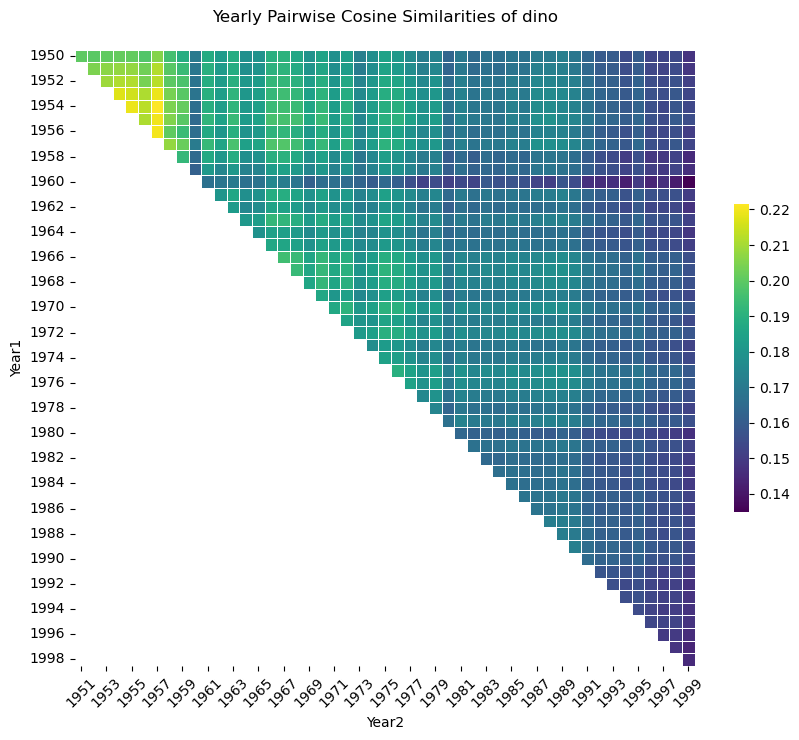

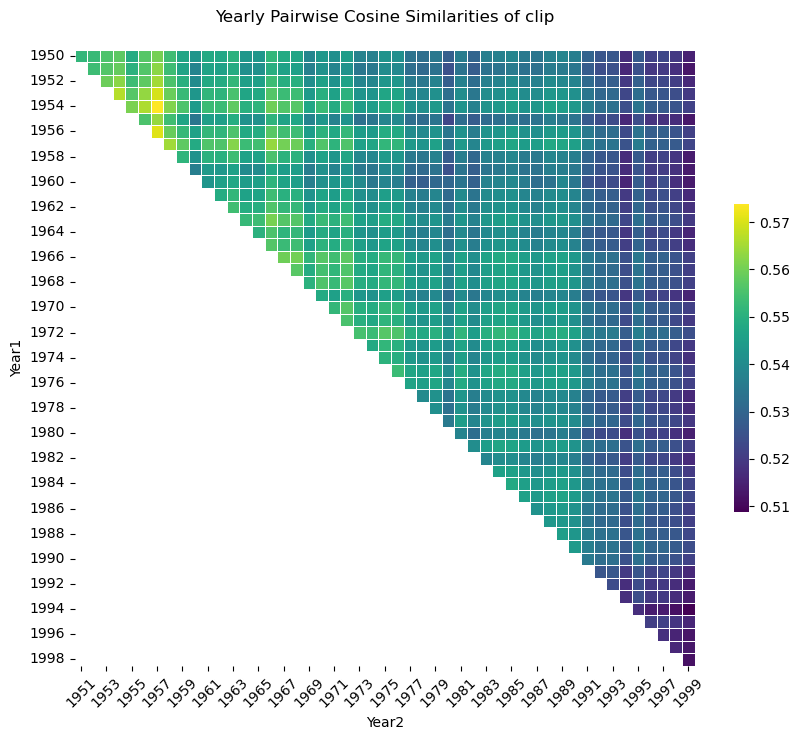

In [28]:
plot_between_years('dino')
plot_between_years('clip')


## Step 2. Calculating Correlation between CLIP and DINO within year

In [29]:
if not os.path.exists('correlations_data.pkl'):
    correlations = {}
    for year, embeddings_dict in tqdm(embeddings_by_year.items(), desc="Calculating correlations"):
            dino_similarity_matrix = calculate_pairwise_cosine_similarity(embeddings_dict['dino'])
            clip_similarity_matrix = calculate_pairwise_cosine_similarity(embeddings_dict['clip'])

            if dino_similarity_matrix is not None and clip_similarity_matrix is not None:
                dino_similarities = flatten_upper_triangle(dino_similarity_matrix)
                clip_similarities = flatten_upper_triangle(clip_similarity_matrix)
                
                num_observations = len(dino_similarities)
                
                pearson_corr, _ = pearsonr(dino_similarities, clip_similarities)
                spearman_corr, _ = spearmanr(dino_similarities, clip_similarities)
                
                correlations[year] = {'pearson': pearson_corr, 'spearman': spearman_corr, 'n_observations': num_observations}
            else:
                correlations[year] = {'pearson': np.nan, 'spearman': np.nan, 'n_observations': 0} 

        
    with open('correlations_data.pkl', 'wb') as file:
        pickle.dump(correlations, file)

else:
    with open('correlations_data.pkl', 'rb') as file:
        correlations = pickle.load(file)
    print("'correlations_data.pkl' was found and data has been loaded.")

'correlations_data.pkl' was found and data has been loaded.


In [36]:
sorted_years = sorted(list(correlations.keys()))



Spearman Model
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     18.38
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           8.68e-05
Time:                        12:13:41   Log-Likelihood:                 107.29
No. Observations:                  50   AIC:                            -210.6
Df Residuals:                      48   BIC:                            -206.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9486      0.559     

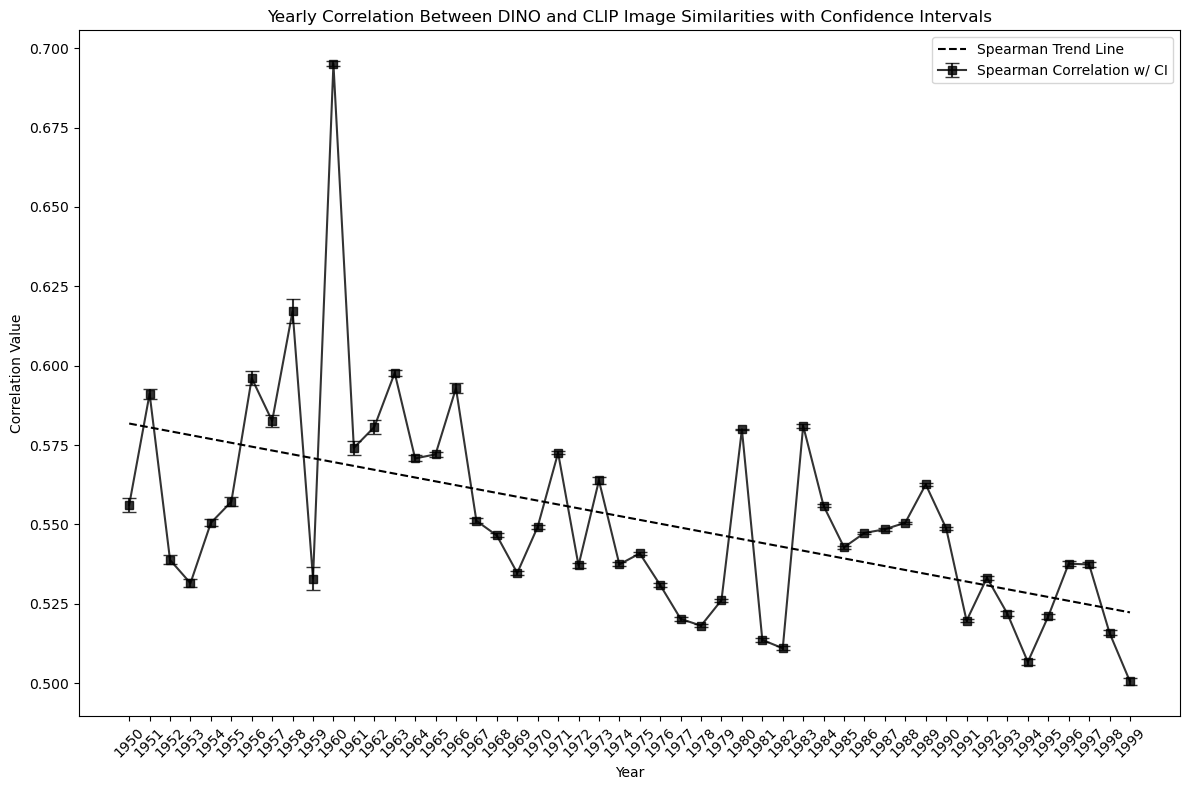

In [41]:
def extract_values(correlations, key):
    '''
    Function to extract values from correlations dictionary
    '''
    return [correlations[year][key] for year in sorted(correlations)]

def calculate_error_bars(values, confidence_intervals):
    '''
    Function to calculate error bars based on confidence intervals
    '''
    lower_limits, upper_limits = zip(*confidence_intervals)
    lower_errors = np.array(values) - np.array(lower_limits)
    upper_errors = np.array(upper_limits) - np.array(values)
    return [lower_errors, upper_errors]

sorted_correlations = {k: correlations[k] for k in sorted(correlations)}
# Extracting sorted values from the correlations dictionary
sorted_years = list(sorted_correlations.keys())
#pearson_values = extract_values(correlations, 'pearson')
spearman_values = extract_values(sorted_correlations, 'spearman')
n_observations = extract_values(sorted_correlations, 'n_observations')

# Calculating confidence intervals
#pearson_confidence_intervals = [calculate_confidence_interval(r, n) for r, n in zip(pearson_values, n_observations)]
spearman_confidence_intervals = [calculate_confidence_interval(r, n) for r, n in zip(spearman_values, n_observations)]

# Calculating error bars
#pearson_errors = calculate_error_bars(pearson_values, pearson_confidence_intervals)
spearman_errors = calculate_error_bars(spearman_values, spearman_confidence_intervals)


# fit a linear regression for correlation values
numerical_years = np.array(sorted_years).astype(float) 

#pearson_coeffs = np.polyfit(numerical_years, sorted_pearson_values, 1)
#pearson_trendline = np.polyval(pearson_coeffs, numerical_years)

spearman_coeffs = np.polyfit(numerical_years, spearman_values, 1)
spearman_trendline = np.polyval(spearman_coeffs, numerical_years)


# Model Summary Spearman
X = sm.add_constant(sorted_years)
Y = spearman_values

model = sm.OLS(Y, X).fit()
print('Spearman Model')
print(model.summary())


# Plotting
plt.figure(figsize=(12, 8))
#plt.errorbar(sorted_years, pearson_values, yerr=pearson_errors, fmt='-o', capsize=5, label='Pearson Correlation w/ CI', color='blue')
plt.errorbar(sorted_years, spearman_values, yerr=spearman_errors, fmt='-s', capsize=5, label='Spearman Correlation w/ CI', color='black', alpha=.8)
#plt.plot(sorted_years, pearson_trendline, label='Pearson Trend Line', color='blue', linestyle='--')
plt.plot(sorted_years, spearman_trendline, label='Spearman Trend Line', color='black', linestyle='--')

plt.title('Yearly Correlation Between DINO and CLIP Image Similarities with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Correlation Value')
plt.xticks(sorted_years, rotation=45)  # Use sorted years for the x-axis
plt.legend()
plt.tight_layout()
plt.savefig('correlations_with_trendline.png', dpi=300)
plt.show()

### (Hierarchical) Clustering

In [43]:
discretized_periods = discretize_years_to_periods(year_list, 5)


In [55]:

import sklearn
from sklearn.decomposition import PCA

In [62]:
def sample_and_sort_embeds(embedding_type, labels, n_components=50, n_samples=10000):
    # Resample your embeddings and corresponding years/labels
    embeds = None
    
    if embedding_type == 'dino':
        embeds = np.array(dino_embeddings['X'])
    elif embedding_type == 'clip':
        embeds = np.array(clip_embeddings['X'])
    else:
        print('use either clip or dino as embedding')
        return None, None 
    
    sampled_embeddings, sampled_labels = sklearn.utils.resample(embeds, labels, n_samples=n_samples, random_state=42)

    pca = PCA(n_components=n_components) 
    reduced_clip_embeddings = pca.fit_transform(sampled_embeddings)

    # Compute the similarity matrix on reduced embeddings
    similarity_matrix = calculate_pairwise_cosine_similarity(reduced_clip_embeddings)
    # Assuming `embeddings` is your numpy array of CLIP embeddings
    similarity_matrix_pca = calculate_pairwise_cosine_similarity(sampled_embeddings)

    sorted_indices = np.argsort(sampled_labels)
    sorted_similarity_matrix = similarity_matrix[sorted_indices, :][:, sorted_indices]
    sorted_similarity_matrix_pca = similarity_matrix_pca[sorted_indices, :][:, sorted_indices]
    return sorted_similarity_matrix, sorted_similarity_matrix_pca

In [63]:
dino_sampled, dino_sampled_pca = sample_and_sort_embeds('dino', year_list)
clip_sampled, clip_sampled_pca = sample_and_sort_embeds('clip', year_list)



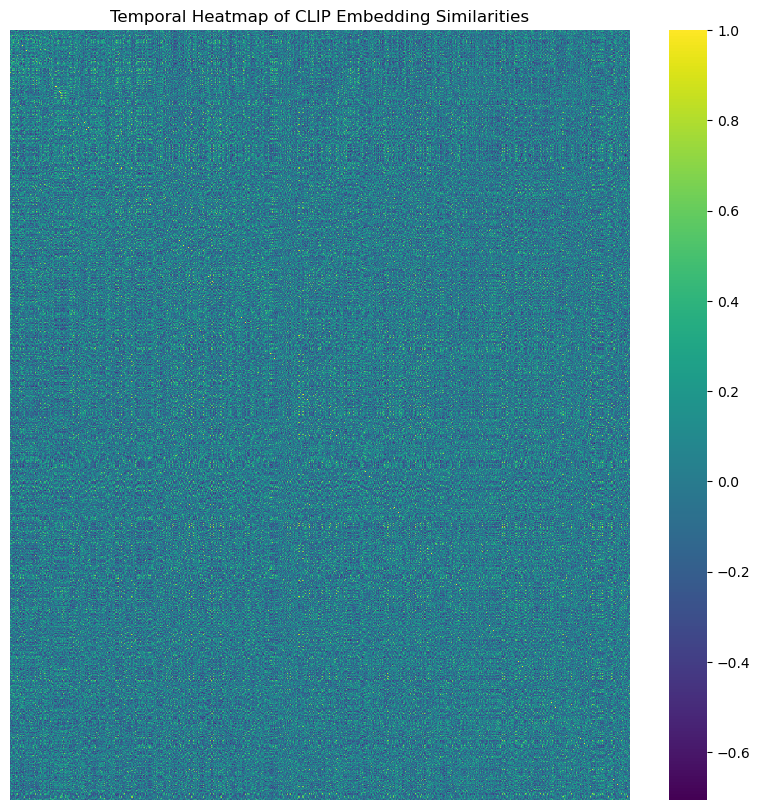

In [64]:
plt.figure(figsize=(10, 10))
sns.heatmap(dino_sampled, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Temporal Heatmap of DINO Embedding Similarities')
plt.show()

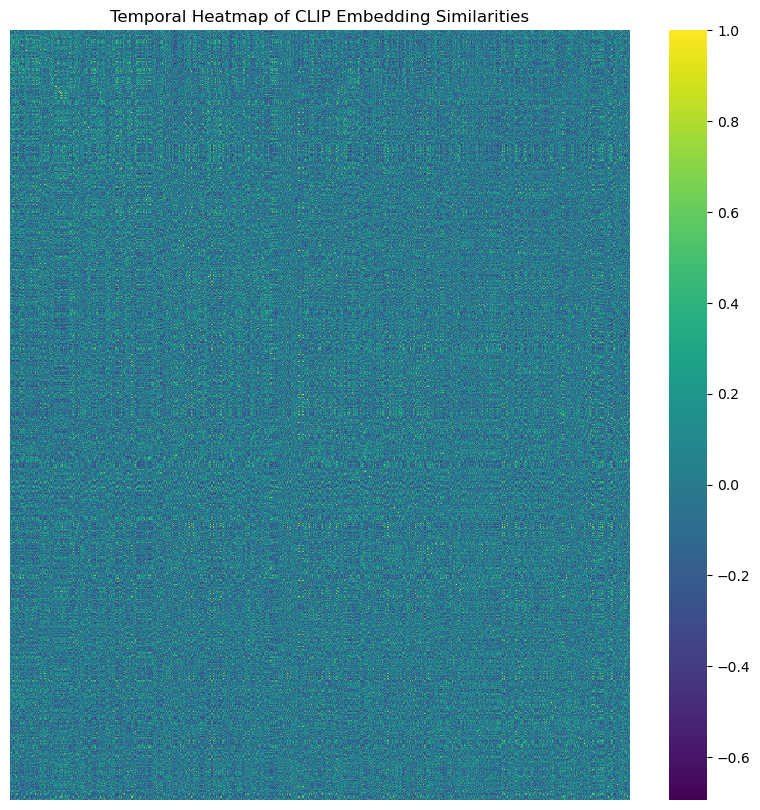

In [66]:
plt.figure(figsize=(10, 10))
sns.heatmap(clip_sampled, cmap='viridis', xticklabels=False, yticklabels=False)
plt.title('Temporal Heatmap of CLIP Embedding Similarities')
plt.show()

#### Similarity Matrix Using Average Embedding Per Year

In [68]:
# todo replace own function with this
from sklearn.metrics.pairwise import cosine_similarity


def compute_average_embeddings(embeddings_by_year):
    average_embeddings = {'clip': [], 'dino': []}
    
    # Sorted years for consistent ordering
    years = sorted(embeddings_by_year.keys())

    # Compute average embeddings for each year and embedding type
    for year in years:
        for embed_type in ['clip', 'dino']:
            average_embeddings[embed_type].append(np.mean(embeddings_by_year[year][embed_type], axis=0))

    return average_embeddings, years


def compute_similarity_matrices(average_embeddings):
    clip_average_embeddings_matrix = np.array(average_embeddings['clip'])
    dino_average_embeddings_matrix = np.array(average_embeddings['dino'])

    # Compute cosine similarity matrices
    clip_similarity_matrix = cosine_similarity(clip_average_embeddings_matrix)
    dino_similarity_matrix = cosine_similarity(dino_average_embeddings_matrix)

    return clip_similarity_matrix, dino_similarity_matrix

average_embeddings, years = compute_average_embeddings(embeddings_by_year)
clip_similarity_matrix, dino_similarity_matrix = compute_similarity_matrices(average_embeddings)



In [69]:

diff_similarity_matrix = clip_similarity_matrix-dino_similarity_matrix

clip_similarity_df = pd.DataFrame(clip_similarity_matrix, index=years, columns=years)
dino_similarity_df = pd.DataFrame(dino_similarity_matrix, index=years, columns=years)
diff_similarity_df = pd.DataFrame(diff_similarity_matrix, index=years, columns=years)


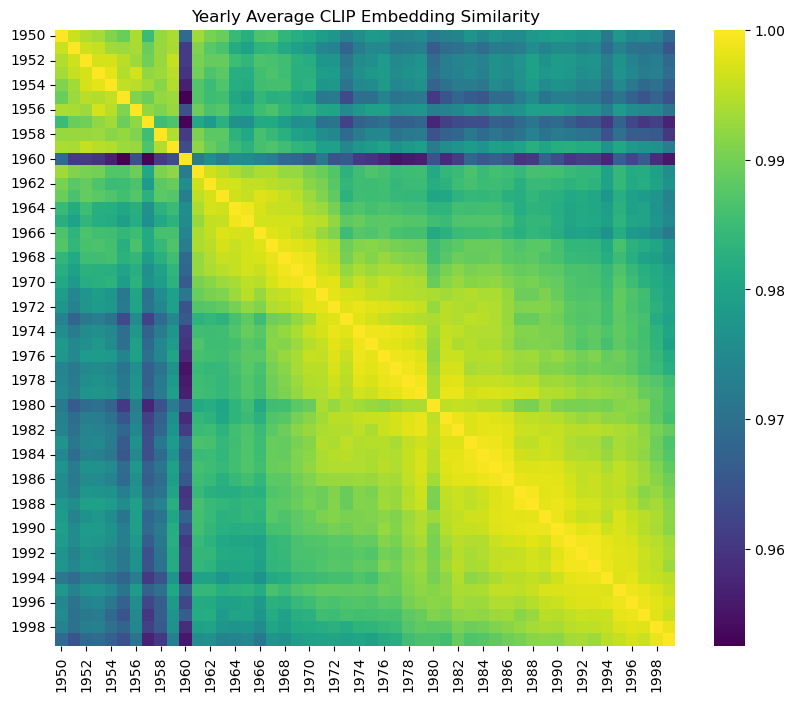

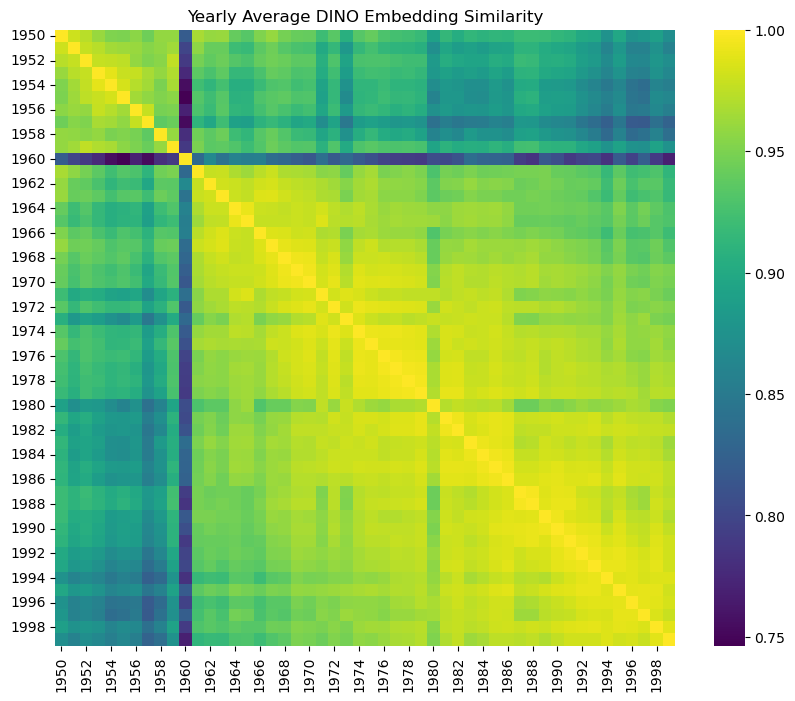

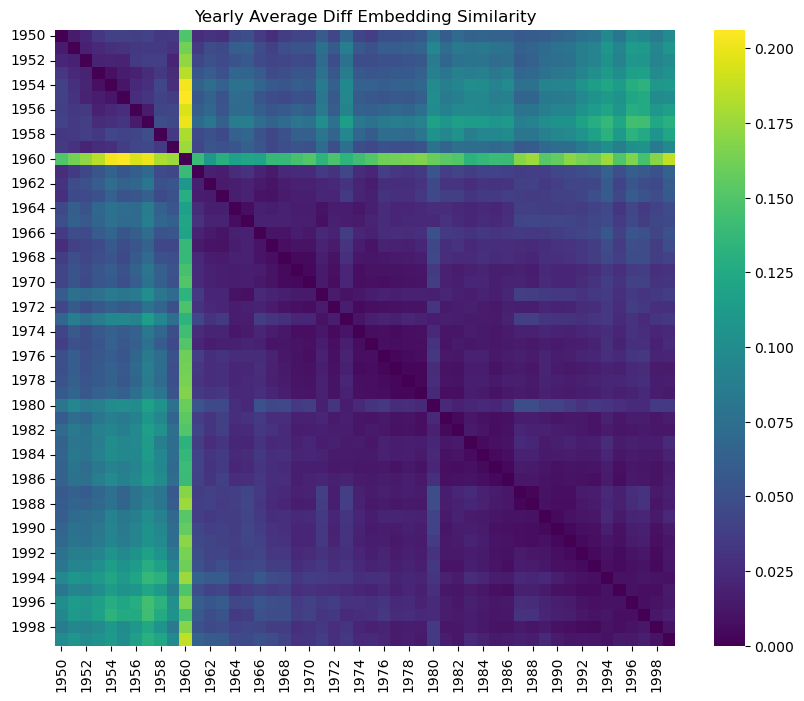

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot similarity heatmap
def plot_similarity_heatmap(similarity_df, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, cmap='viridis', annot=False, fmt=".3f")
    plt.title(title)
    plt.show()


# Plot heatmaps for CLIP and DINO
plot_similarity_heatmap(clip_similarity_df, "Yearly Average CLIP Embedding Similarity")
plot_similarity_heatmap(dino_similarity_df, "Yearly Average DINO Embedding Similarity")
plot_similarity_heatmap(diff_similarity_df, "Yearly Average Diff Embedding Similarity")


In [71]:
pearsonr(clip_similarity_matrix.flatten(), dino_similarity_matrix.flatten())

PearsonRResult(statistic=0.9435247607982788, pvalue=0.0)

The matrices are very strongly correlated, so basically the same. 

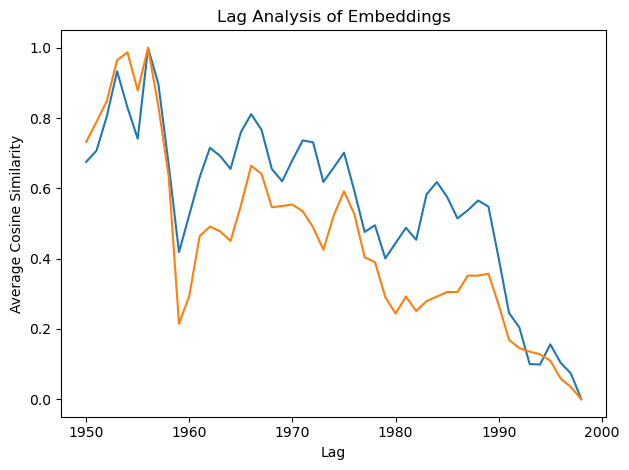

In [85]:
embedding_types = ['clip', 'dino']
lag_similarities = {embedding_type: {} for embedding_type in embedding_types}

for embedding_type in embedding_types:
    for year in range(years[0], years[-1]):  # 'years' is a sorted list of unique years in your dataset
        if year + 2 not in embeddings_by_year:  # Check if the next year is in the dataset
            continue

        current_year_images = embeddings_by_year[year][embedding_type]
        next_year_images = embeddings_by_year[year + 1][embedding_type]
        #lag = year - years[0]  # Adjusted lag calculation to start from 0
        
        # Calculate pairwise similarities between current year and next year images
        similarities = cosine_similarity(current_year_images, next_year_images)
        lag_similarities[embedding_type][year] = np.mean(similarities)

# Plotting side by side
fig, ax = plt.subplots()
normalized = True
for i, embedding_type in enumerate(embedding_types):
    y = list(lag_similarities[embedding_type].values())
    y_normalized = (y - np.min(y)) / (np.max(y) - np.min(y))
    if normalized:
        ax.plot(list(lag_similarities[embedding_type].keys()), y_normalized)
    else:
        ax.plot(list(lag_similarities[embedding_type].keys()), y)
ax.set_xlabel('Lag')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title(f'Lag Analysis of Embeddings')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


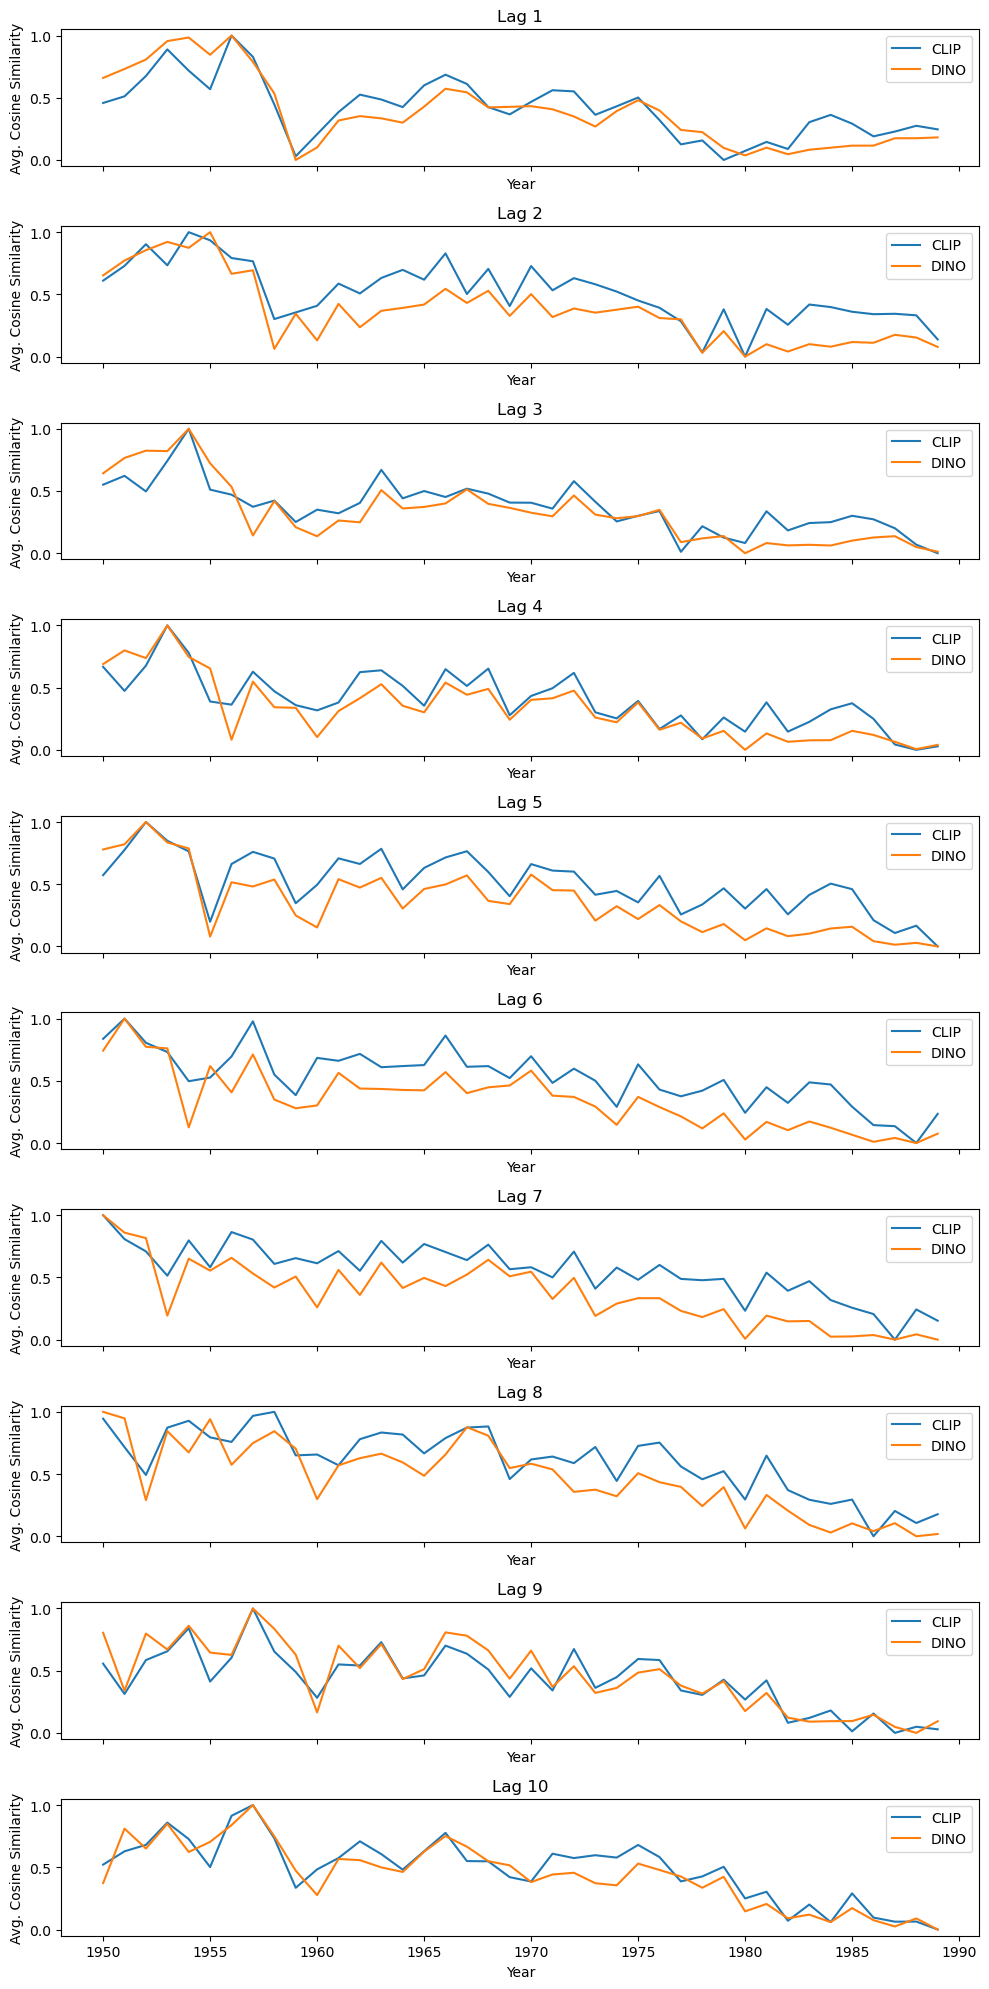

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming max_lag and lag_similarities are defined as in the previous example
max_lag = 10  # Example max lag

# Plotting in a single column grid, each lag on a separate subplot
fig, axs = plt.subplots(max_lag, 1, figsize=(10, 20), sharex=True)

for lag in range(1, max_lag + 1):
    ax = axs[lag - 1]  # Select the appropriate subplot
    
    for embedding_type in embedding_types:
        y = lag_similarities[embedding_type][lag]
        
        # Check if normalization is required
        if normalized:
            y = (y - np.min(y)) / (np.max(y) - np.min(y))
        
        ax.plot(range(years[0], years[0] + len(y)), y, label=f'{embedding_type.upper()}')

    ax.set_title(f'Lag {lag}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Avg. Cosine Similarity')
    ax.legend()

plt.tight_layout()
plt.show()


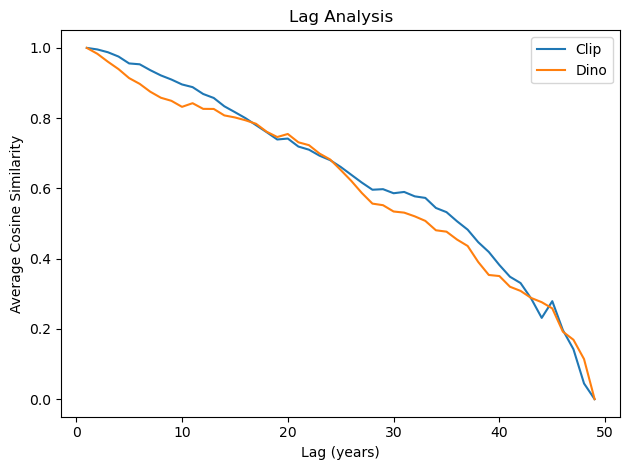

In [84]:
embedding_types = ['clip', 'dino']
lag_similarities = {embedding_type: {} for embedding_type in embedding_types}

for embedding_type in embedding_types:
    for start_year in range(years[0], years[-1]):
        for lag in range(1, (years[-1] - start_year) + 1):  # Iterate through all possible lags
            if (start_year + lag) not in embeddings_by_year:  # Check if the lagged year is in the dataset
                continue

            current_year_images = embeddings_by_year[start_year][embedding_type]
            lagged_year_images = embeddings_by_year[start_year + lag][embedding_type]
            
            # Calculate pairwise similarities between current year and lagged year images
            similarities = cosine_similarity(current_year_images, lagged_year_images)
            if lag not in lag_similarities[embedding_type]:
                lag_similarities[embedding_type][lag] = []
            lag_similarities[embedding_type][lag].append(np.mean(similarities))

# Averaging the similarities for each lag across all start years
for embedding_type in embedding_types:
    for lag in lag_similarities[embedding_type]:
        lag_similarities[embedding_type][lag] = np.mean(lag_similarities[embedding_type][lag])

# Plotting
fig, ax = plt.subplots()  # 1 row, 2 columns for 'clip' and 'dino'

for i, embedding_type in enumerate(embedding_types):
    lags = list(lag_similarities[embedding_type].keys())
    avg_similarities = list(lag_similarities[embedding_type].values())
    
    # Normalizing if required
    if normalized:
        avg_similarities = (avg_similarities - np.min(avg_similarities)) / (np.max(avg_similarities) - np.min(avg_similarities))
    
    ax.plot(lags, avg_similarities, label=embedding_type.capitalize())
ax.set_xlabel('Lag (years)')
ax.set_ylabel('Average Cosine Similarity')
ax.set_title(f'Lag Analysis')
ax.legend()

plt.tight_layout()
plt.show()


high correlation persists at higher lag. So more auto-correlation, more temporal information encoded in CLIP??

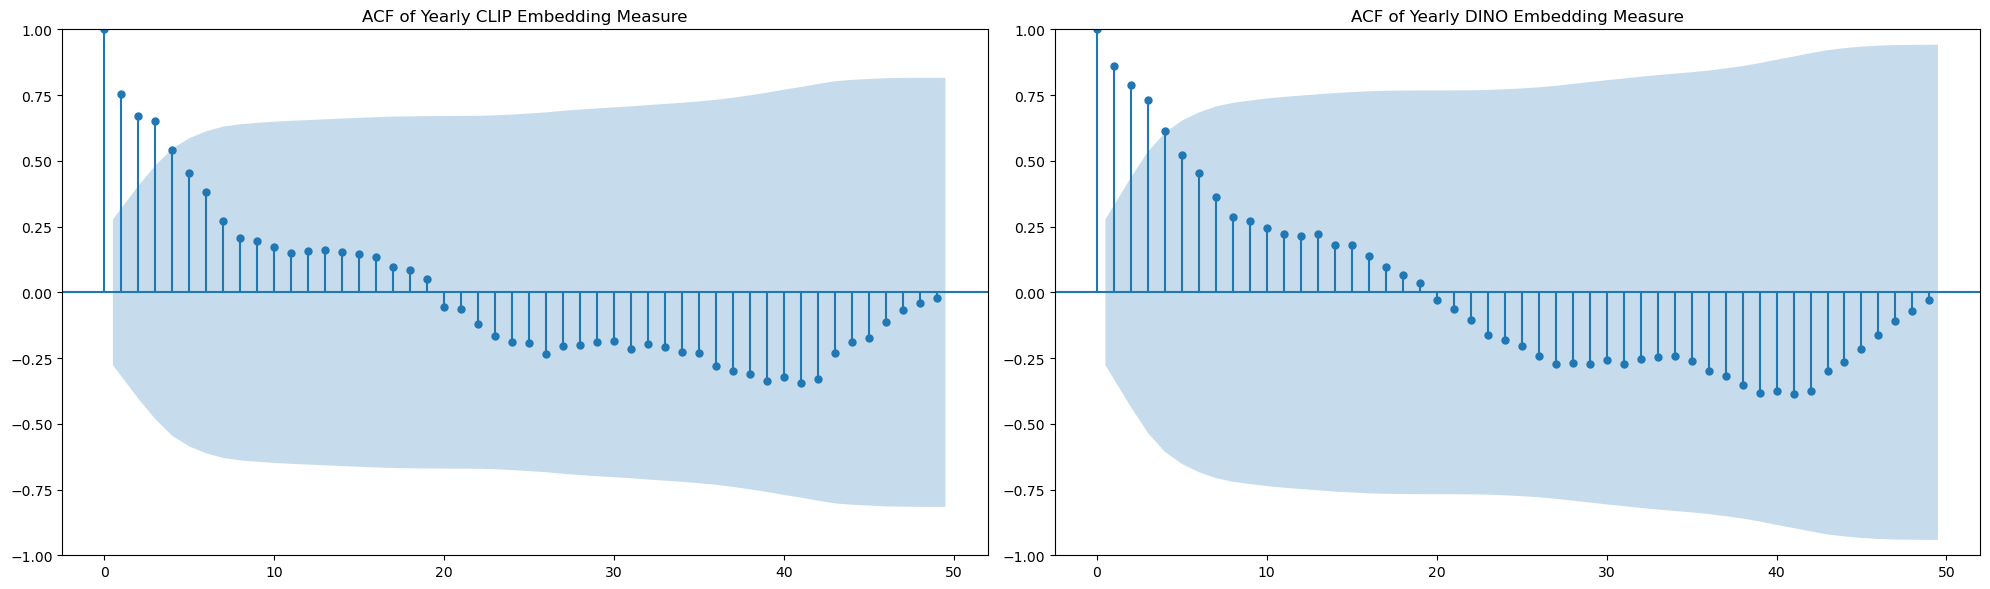

In [115]:
embedding_types = ['clip', 'dino']
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

for i, embedding_type in enumerate(embedding_types):
    yearly_measure = {}

    for year, embeddings in embeddings_by_year.items():
        # Calculate pairwise cosine similarity for the embedding type and then take the average
        similarity_matrix = calculate_pairwise_cosine_similarity(embeddings[embedding_type])
        avg_similarity = np.mean(similarity_matrix)
        yearly_measure[year] = avg_similarity

    # Ensure the years are sorted and create the time series list
    sorted_years = sorted(yearly_measure.keys())
    time_series = [yearly_measure[year] for year in sorted_years]

    # Generate the ACF plot for the current embedding type
    plot_acf(time_series, ax=axs[i], lags=len(time_series)-1, title=f'ACF of Yearly {embedding_type.upper()} Embedding Measure')

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


### prototypes

In [146]:
from collections import defaultdict

period_list = []
period_embeddings = defaultdict(list)
period_images = defaultdict(list)
for embedding, year, image_id, object_label in zip(clip_embeddings['X'], year_list, ids, labels): 
    period = (year // 5) * 5  # Determine the 5-year period
    name, extension = image_id.rsplit('.', 1)
    modified_id = f'{name}_obj_{object_label}.{extension}'
    period_list.append(period)
    period_embeddings[period].append(embedding)
    period_images[period].append(modified_id)

In [147]:
period_images[1970]

['NL-HlmNHA_1478_10631K00_01_obj_4.jpg',
 'NL-HlmNHA_1478_11697K00_10_obj_5.jpg',
 'NL-HlmNHA_1478_10598K00_03_obj_0.jpg',
 'NL-HlmNHA_1478_10386K00_07_obj_5.jpg',
 'NL-HlmNHA_1478_13483K00_20_obj_14.jpg',
 'NL-HlmNHA_1478_13362K00_16_obj_2.jpg',
 'NL-HlmNHA_1478_10281K00_28_obj_2.jpg',
 'NL-HlmNHA_1478_10232K02_01_obj_7.jpg',
 'NL-HlmNHA_1478_10830K00_31_obj_0.jpg',
 'NL-HlmNHA_1478_12950K00_19_obj_0.jpg',
 'NL-HlmNHA_1478_13332K00_11_obj_0.jpg',
 'NL-HlmNHA_1478_12346K00_29_obj_3.jpg',
 'NL-HlmNHA_1478_09744K00_04_obj_0.jpg',
 'NL-HlmNHA_1478_11849K01_12_obj_8.jpg',
 'NL-HlmNHA_1478_10546K00_37_obj_3.jpg',
 'NL-HlmNHA_1478_13137K00_18_obj_4.jpg',
 'NL-HlmNHA_1478_09983K00_33_obj_1.jpg',
 'NL-HlmNHA_1478_11697K00_02_obj_3.jpg',
 'NL-HlmNHA_1478_12584K00_28_obj_0.jpg',
 'NL-HlmNHA_1478_12476K00_07_obj_9.jpg',
 'NL-HlmNHA_1478_08046K00_20_obj_0.jpg',
 'NL-HlmNHA_1478_13448K00_05_obj_0.jpg',
 'NL-HlmNHA_1478_08290K00_25_obj_7.jpg',
 'NL-HlmNHA_1478_10835K00_09_obj_2.jpg',
 'NL-HlmNHA_147

In [104]:
period_prototypes = {}
for period, embeddings in period_embeddings.items():
    mean_embedding = np.mean(embeddings, axis=0)
    distances = np.linalg.norm(embeddings - mean_embedding, axis=1)
    
    # Get indices of the 10 closest images
    prototypical_indices = np.argsort(distances)[:10]
    
    # Select the 10 closest images based on the indices
    closest_images = [period_images[period][idx] for idx in prototypical_indices]
    
    period_prototypes[period] = closest_images


In [247]:
period_prototypes

{1985: ['NL-HlmNHA_1478_29317K00_29.jpg',
  'NL-HlmNHA_1478_31391K00_07.jpg',
  'NL-HlmNHA_1478_29069K01_20.jpg',
  'NL-HlmNHA_1478_27830K00_40.jpg',
  'NL-HlmNHA_1478_29586K00_21.jpg',
  'NL-HlmNHA_1478_29954K00_37.jpg',
  'NL-HlmNHA_1478_30575K00_25.jpg',
  'NL-HlmNHA_1478_29069K01_20.jpg',
  'NL-HlmNHA_1478_25986K00_13.jpg',
  'NL-HlmNHA_1478_25360K01_11.jpg'],
 1965: ['NL-HlmNHA_1478_03449K00_12.jpg',
  'NL-HlmNHA_1478_06331K00_11.jpg',
  'NL-HlmNHA_1478_NN064K00_05.jpg',
  'NL-HlmNHA_1478_03284K00_17.jpg',
  'NL-HlmNHA_1478_06087K00_20.jpg',
  'NL-HlmNHA_1478_05295K02_16.jpg',
  'NL-HlmNHA_1478_02297A00_12.jpg',
  'NL-HlmNHA_1478_06429K00_34.jpg',
  'NL-HlmNHA_1478_06166K00_05.jpg',
  'NL-HlmNHA_1478_07330K00_37.jpg'],
 1995: ['NL-HlmNHA_1478_46039K00_13.jpg',
  'NL-HlmNHA_1478_45466K00_25.jpg',
  'NL-HlmNHA_1478_47755K00_15.jpg',
  'NL-HlmNHA_1478_42344K00_25.jpg',
  'NL-HlmNHA_1478_46815K00_38.jpg',
  'NL-HlmNHA_1478_44108K00_31.jpg',
  'NL-HlmNHA_1478_45082K00_02.jpg',
  'NL-Hl

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


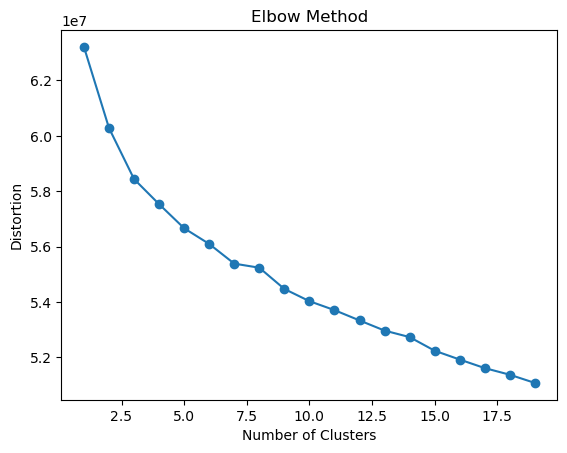

In [144]:
distortions = []
for i in range(1, 20):
    print(i)
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(dino_embeds)
    distortions.append(kmeans.inertia_)  # inertia_ represents the sum of squared distances to the closest centroid

plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [145]:
### compare to kmeans clustering

from sklearn.cluster import KMeans

# Example using KMeans, adjust 'n_clusters' as needed
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(dino_embeds)

In [146]:
import pandas as pd

# Assuming 'image_years' is a list/array of years corresponding to each image in the same order as 'all_embeddings'
df = pd.DataFrame({'period': period_list, 'cluster': clusters})
cluster_temporal_distribution = df.groupby('cluster')['period'].value_counts().unstack(fill_value=0)


In [147]:
cluster_temporal_distribution

period   1950  1955  1960  1965  1970  1975  1980  1985  1990  1995
cluster                                                            
0        1046   641   870  2176  2942  3915  4155  4475  3012  2175
1        1677  1254  1265  2362  2634  3735  3018  3720  2158  1590
2         182    78  1091  1309  1972  1954  3370  2212  1358  1385
3        2249  1315  2421  3687  3917  5193  6051  7358  4257  3379
4        1475   801  1633  2257  2811  4167  5387  7147  4997  4092

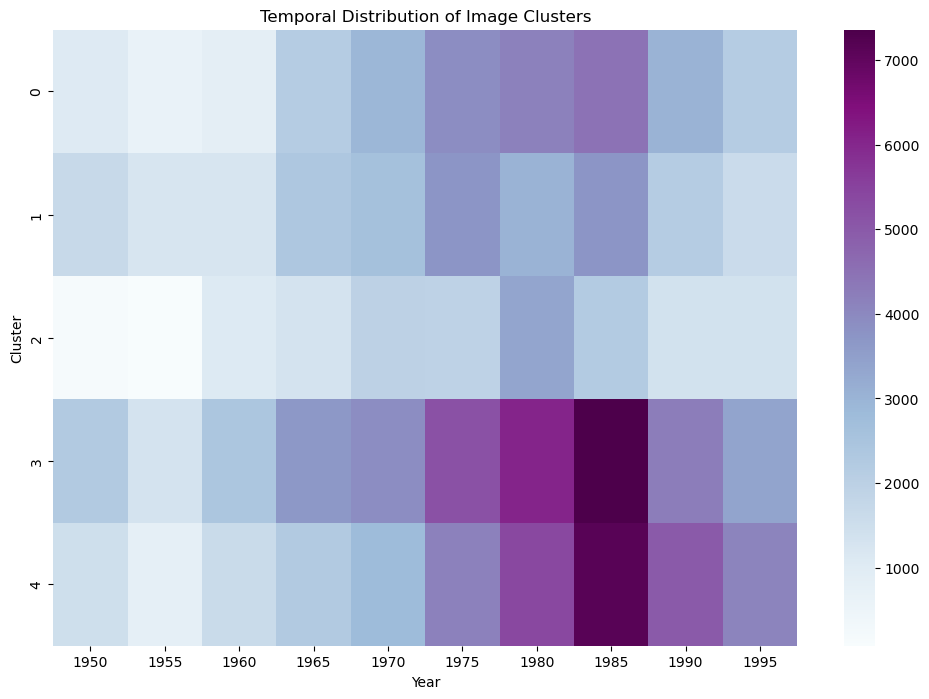

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_temporal_distribution, annot=False, fmt="d", cmap="BuPu")
plt.title("Temporal Distribution of Image Clusters")
plt.ylabel("Cluster")
plt.xlabel("Year")
plt.show()


In [241]:
pca = PCA(n_components=10) 
reduced_clip_embeddings = pca.fit_transform(clip_embeds)

In [ ]:
###hiearchical clustering

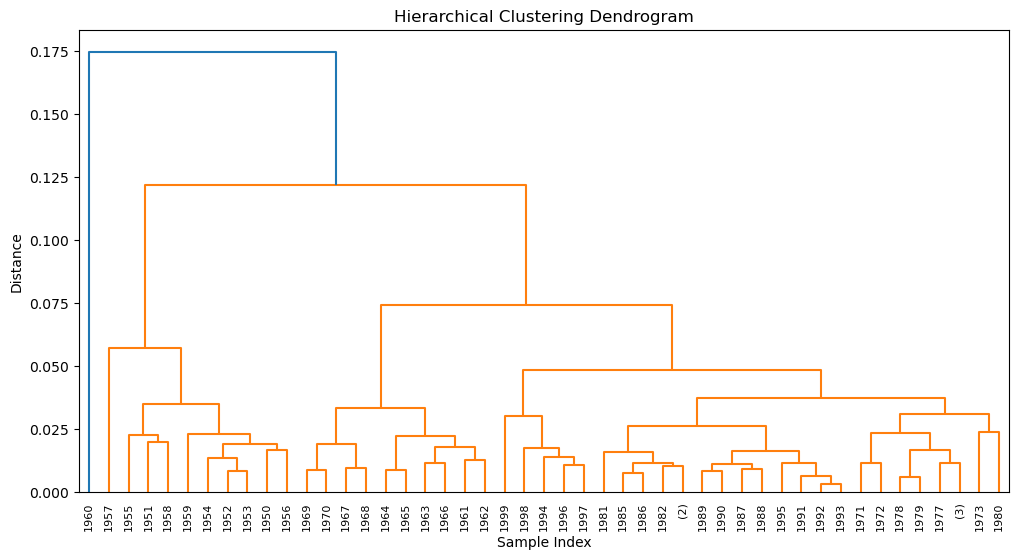

In [217]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

threshold = 8


Z = linkage(clip_similarity_matrix, method='average', metric='euclidean')

# Step 4: Visualize the Dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z,truncate_mode='level', p=threshold, labels=years)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [243]:
num_samples = 10000  # Choose the number of samples based on your dataset size and available memory

indices = np.random.choice(clip_embeddings['X'].shape[0], num_samples, replace=False)
sorted_indices = np.sort(indices)

sampled_embeddings = clip_embeddings['X'][sorted_indices]
sampled_periods = np.array(discretized_periods)[sorted_indices]


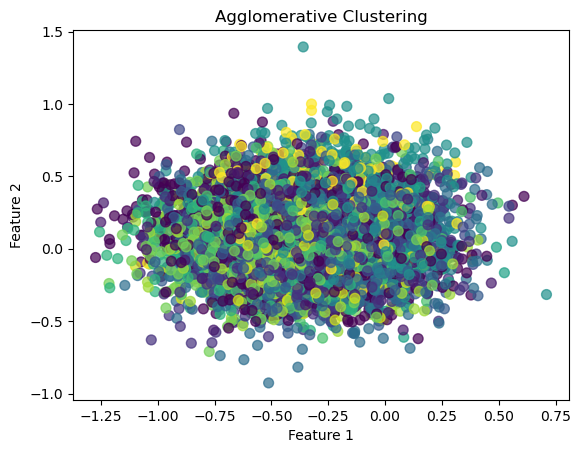

In [244]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=15)
clustering.fit(sampled_embeddings)

# Plot the clustered data
plt.scatter(sampled_embeddings[:, 0], sampled_embeddings[:, 1], c=clustering.labels_, cmap='viridis', s=50, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()